In [1]:

import os, glob, re, gzip, shutil, json
from os.path import join
import pathlib
import numpy as np
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn import image, plotting
import argparse
from nilearn.image import new_img_like, resample_to_img, math_img
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

In [83]:
__author__ = "Heejung Jung"
__copyright__ = "Spatial Topology Project"
__credits__ = ["Heejung"] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung@colorado.edu"
__status__ = "Development" 

# main_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue'
main_dir = '/Volumes/spacetop_projects_cue'


Let's get our contrast of interest. I'll query the index of the contrat from this list

In [84]:
contrast_list = [
    'P_VC_STIM_cue_high_gt_low', 'V_PC_STIM_cue_high_gt_low', 'C_PV_STIM_cue_high_gt_low',
    'P_VC_STIM_stimlin_high_gt_low', 'V_PC_STIM_stimlin_high_gt_low', 'C_PV_STIM_stimlin_high_gt_low',
    'P_VC_STIM_stimquad_med_gt_other', 'V_PC_STIM_stimquad_med_gt_other', 'C_PV_STIM_stimquad_med_gt_other',
    'P_VC_STIM_cue_int_stimlin','V_PC_STIM_cue_int_stimlin', 'C_PV_STIM_cue_int_stimlin',
    'P_VC_STIM_cue_int_stimquad','V_PC_STIM_cue_int_stimquad','C_PV_STIM_cue_int_stimquad',
    'motor',
    'P_simple_STIM_cue_high_gt_low',      'V_simple_STIM_cue_high_gt_low', 'C_simple_STIM_cue_high_gt_low',
    'P_simple_STIM_stimlin_high_gt_low',  'V_simple_STIM_stimlin_high_gt_low', 'C_simple_STIM_stimlin_high_gt_low',
    'P_simple_STIM_stimquad_med_gt_other','V_simple_STIM_stimquad_med_gt_other', 'C_simple_STIM_stimquad_med_gt_other',
    'P_simple_STIM_cue_int_stimlin',      'V_simple_STIM_cue_int_stimlin', 'C_simple_STIM_cue_int_stimlin',
    'P_simple_STIM_cue_int_stimquad',     'V_simple_STIM_cue_int_stimquad','C_simple_STIM_cue_int_stimquad',
    'P_simple_STIM_highcue_highstim',     'P_simple_STIM_highcue_medstim', 'P_simple_STIM_highcue_lowstim',
    'P_simple_STIM_lowcue_highstim',      'P_simple_STIM_lowcue_medstim', 'P_simple_STIM_lowcue_lowstim',
    'V_simple_STIM_highcue_highstim',     'V_simple_STIM_highcue_medstim', 'V_simple_STIM_highcue_lowstim',
    'V_simple_STIM_lowcue_highstim',      'V_simple_STIM_lowcue_medstim', 'V_simple_STIM_lowcue_lowstim',
    'C_simple_STIM_highcue_highstim',    'C_simple_STIM_highcue_medstim', 'C_simple_STIM_highcue_lowstim',
    'C_simple_STIM_lowcue_highstim',    'C_simple_STIM_lowcue_medstim', 'C_simple_STIM_lowcue_lowstim',
    'P_VC_CUE_cue_high_gt_low','V_PC_CUE_cue_high_gt_low','C_PV_CUE_cue_high_gt_low',
    'P_simple_CUE_cue_high_gt_low','V_simple_CUE_STIM_cue_high_gt_low','C_simple_CUE_cue_high_gt_low',
    'G_simple_CUE_cue_high_gt_low',
    'P_VC_STIM', 'V_PC_STIM', 'C_PV_STIM'
]

### load mask

In [168]:
imgfname = join(main_dir, 'analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz')
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine=ref_img.affine, target_shape=ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img=mask_img, smoothing_fwhm=6,
                                            target_affine=ref_img.affine, target_shape=ref_img.shape, 
                                            memory_level=1)
spm_masker = nilearn.maskers.NiftiMasker(mask_img=mask_img, smoothing_fwhm=None,
                                            target_affine=ref_img.affine, target_shape=ref_img.shape, 
                                            memory_level=1)

## single trial data
identify participants

In [88]:
# load singletrial group data
beta_dir = join(main_dir, 'analysis/fmri/nilearn/deriv05_singletrialnpy')
suballLv = np.load(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.npy"))

with open(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.json"), 'r') as file:
    suballHjson = json.load(file)
with open(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.json"), 'r') as file:
    suballLjson = json.load(file)
# identify intersection of high and low cue arrays 
nilearn_non_intersection = list(set(suballHjson['sub']).symmetric_difference(set(suballLjson['sub'])))
nilearn_intersection = sorted(list(set(suballHjson['sub']).intersection(set(suballLjson['sub']))))
print(f"* any high trials that are non in low pain trials?: {nilearn_non_intersection}")
print(f"* intersection of subjects with high and low pain trials?: {nilearn_intersection}")

* any high trials that are non in low pain trials?: []
* intersection of subjects with high and low pain trials?: ['sub-0002', 'sub-0003', 'sub-0004', 'sub-0005', 'sub-0006', 'sub-0007', 'sub-0008', 'sub-0009', 'sub-0010', 'sub-0011', 'sub-0013', 'sub-0014', 'sub-0015', 'sub-0016', 'sub-0017', 'sub-0018', 'sub-0019', 'sub-0021', 'sub-0023', 'sub-0024', 'sub-0025', 'sub-0026', 'sub-0028', 'sub-0029', 'sub-0030', 'sub-0031', 'sub-0032', 'sub-0033', 'sub-0034', 'sub-0035', 'sub-0036', 'sub-0037', 'sub-0038', 'sub-0039', 'sub-0040', 'sub-0041', 'sub-0043', 'sub-0044', 'sub-0047', 'sub-0050', 'sub-0051', 'sub-0052', 'sub-0053', 'sub-0055', 'sub-0056', 'sub-0057', 'sub-0058', 'sub-0059', 'sub-0060', 'sub-0061', 'sub-0062', 'sub-0063', 'sub-0064', 'sub-0066', 'sub-0068', 'sub-0069', 'sub-0070', 'sub-0073', 'sub-0074', 'sub-0076', 'sub-0077', 'sub-0078', 'sub-0079', 'sub-0080', 'sub-0081', 'sub-0082', 'sub-0083', 'sub-0084', 'sub-0085', 'sub-0086', 'sub-0087', 'sub-0088', 'sub-0089', 'sub-0090

## SPM contrast 
identify participants
### a) stack SPM contrasts and T maps

In [155]:
main_dir
contrast_of_interest = 'P_simple_STIM_stimlin_high_gt_low'
contrast_index = contrast_list.index(contrast_of_interest)
con_list = sorted(glob.glob(join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel', '**', f'*con_{contrast_index:04d}.nii'), recursive='**'))
con_niis = image.concat_imgs(con_list)
from pathlib import Path

# target_dir = Path(join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel'))
# spmsub = [p.name for p in target_dir.iterdir() if p.is_dir() and p.name.startswith("sub-")]
# print(spmsub)



spmsub = [re.search(r'sub-\d+', path).group(0) for path in con_list if re.search(r'sub-\d+', path)]
print(spmsub)


['sub-0014', 'sub-0026', 'sub-0028', 'sub-0029', 'sub-0030', 'sub-0031', 'sub-0033', 'sub-0035', 'sub-0039', 'sub-0040', 'sub-0041', 'sub-0043', 'sub-0044', 'sub-0047', 'sub-0050', 'sub-0051', 'sub-0053', 'sub-0055', 'sub-0058', 'sub-0060', 'sub-0061', 'sub-0062', 'sub-0064', 'sub-0066', 'sub-0068', 'sub-0069', 'sub-0070', 'sub-0073', 'sub-0074', 'sub-0076', 'sub-0077', 'sub-0078', 'sub-0079', 'sub-0080', 'sub-0081', 'sub-0082', 'sub-0084', 'sub-0085', 'sub-0086', 'sub-0088', 'sub-0089', 'sub-0090', 'sub-0092', 'sub-0093', 'sub-0094', 'sub-0095', 'sub-0097', 'sub-0098', 'sub-0099', 'sub-0100', 'sub-0101', 'sub-0102', 'sub-0103', 'sub-0104', 'sub-0106', 'sub-0107', 'sub-0109', 'sub-0114', 'sub-0115', 'sub-0116', 'sub-0118', 'sub-0119', 'sub-0120', 'sub-0122', 'sub-0123', 'sub-0124', 'sub-0126', 'sub-0127', 'sub-0128', 'sub-0129', 'sub-0130', 'sub-0131']


# Problemspace:
* problem space: SPM has less participants compared to nilearn
* TODO: first identify the intersection between SPM and nilearn
* TODO: remove the non overlapping rows in the nilearn array: suballLv, suballHv
* TODO: rerun SPM with the full participants and full runs. 
* NOTE: check scripts/step04_SPM/6conditions/failed_spm.py

In [157]:
print(f"* number of SPM maps: {len(spmsub)}")
print(f"* number of single trials: {len(suballHv)}")

* number of SPM maps: 72
* number of single trials: 110


In [158]:
con_niis.shape

(73, 86, 73, 72)

# interim: intersection of SPM and nilearn



In [159]:
spmnl_non_intersection = sorted(list(set(sorted(spmsub)).symmetric_difference(set(nilearn_intersection))))
spmnl_intersection = sorted(list(set(sorted(spmsub)).intersection(set(nilearn_intersection))))

# Get the indices of the intersection in slist
intersection_indices = [nilearn_intersection.index(item) for item in spmnl_intersection]

# Subset the original numpy array based on the intersection indices
subset_suballLv = suballLv[intersection_indices, :]
subset_suballHv = suballHv[intersection_indices, :]

print(f"shape of single trials, intersection with SPM: {subset_suballLv.shape}")  # Shape: (49, 458294)

shape of single trials, intersection with SPM: (72, 458294)


In [174]:
# single trial Tmaps
x,y,z=ref_img.shape
Hp = []
Lp = []
for index in range(subset_suballLv.shape[0]):
    Hp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, subset_suballHv[index].reshape(x,y,z)))
    )
    Lp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, subset_suballLv[index].reshape(x,y,z)))
    )
fmri_masked_stimhighp = np.vstack(Hp)
fmri_masked_stimlowp = np.vstack(Lp)

nilearn_tvalues, nilearn_pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis=0, nan_policy='propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(nilearn_pvalues, method='fdr_bh')
unthres_tmap = nifti_masker.inverse_transform(nilearn_tvalues)

result_map = np.zeros(fmri_masked_stimhighp.shape[1])
result_map[qvalues < .05] = nilearn_tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhighp.shape[1])
result_map_001[qvalues < .0001] = nilearn_tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)


ValueError: The number cut_coords passed does not match the display_mode. Mosaic plotting expects tuple of length 3.

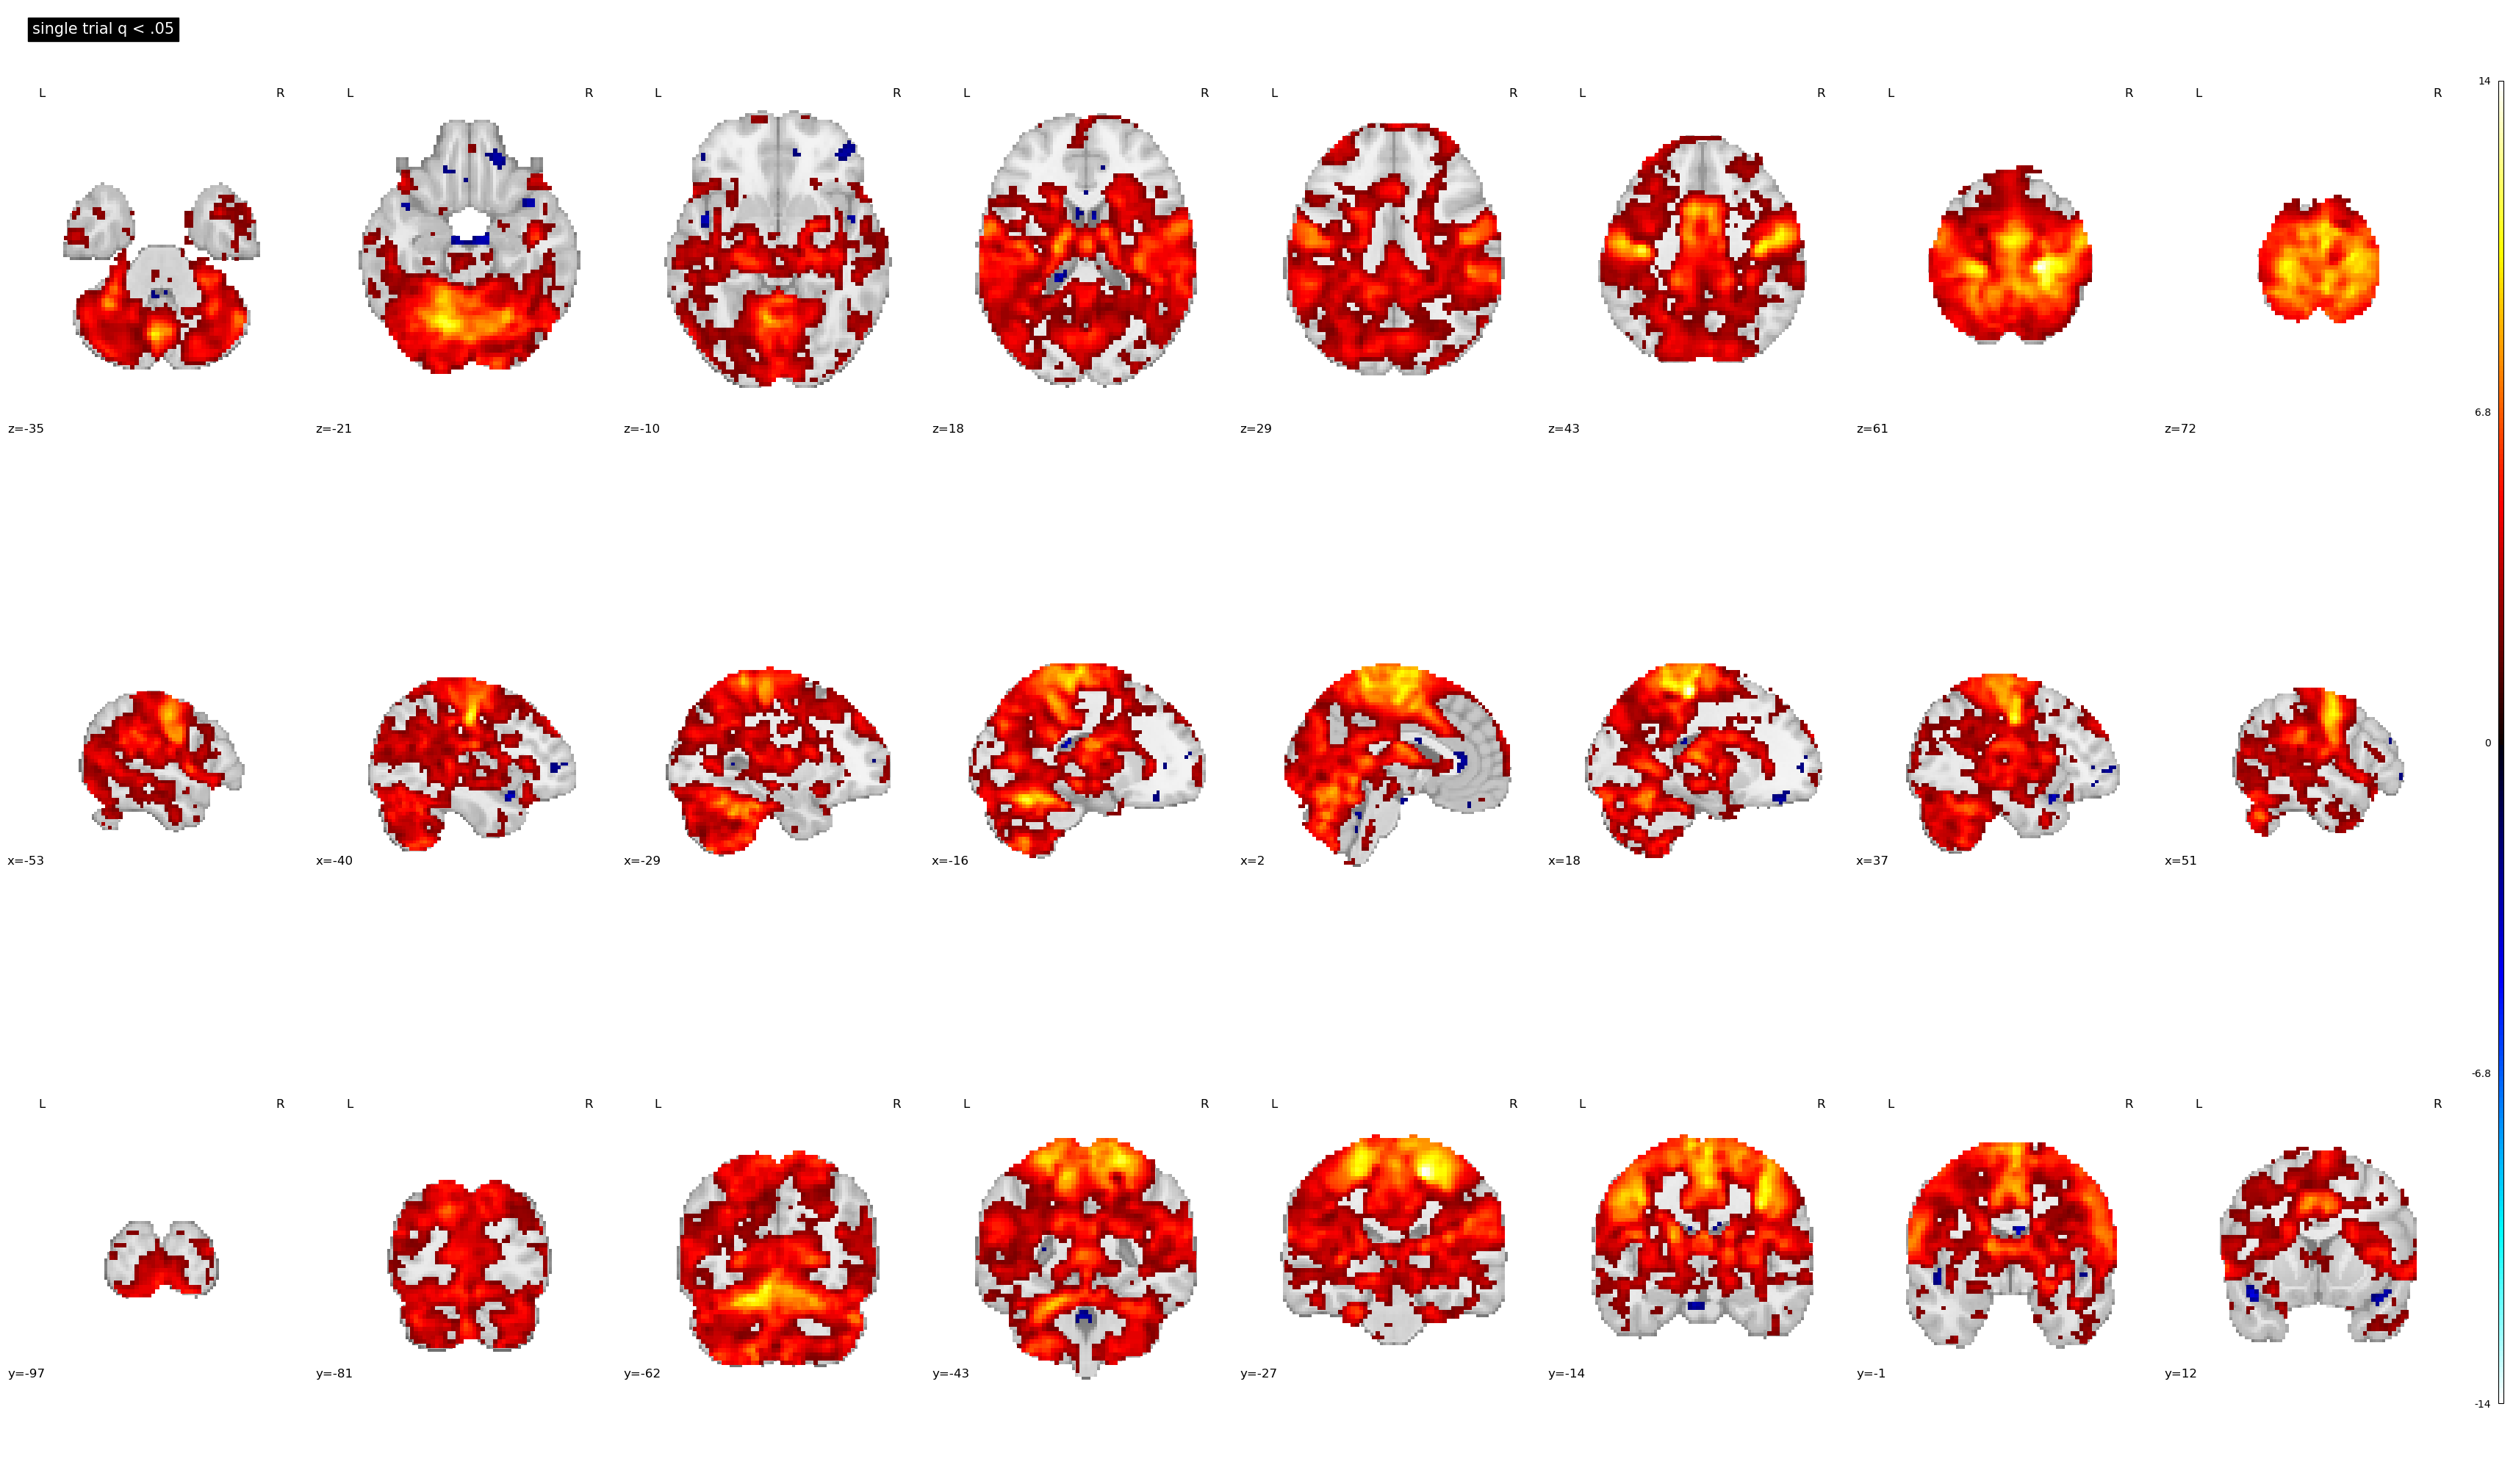

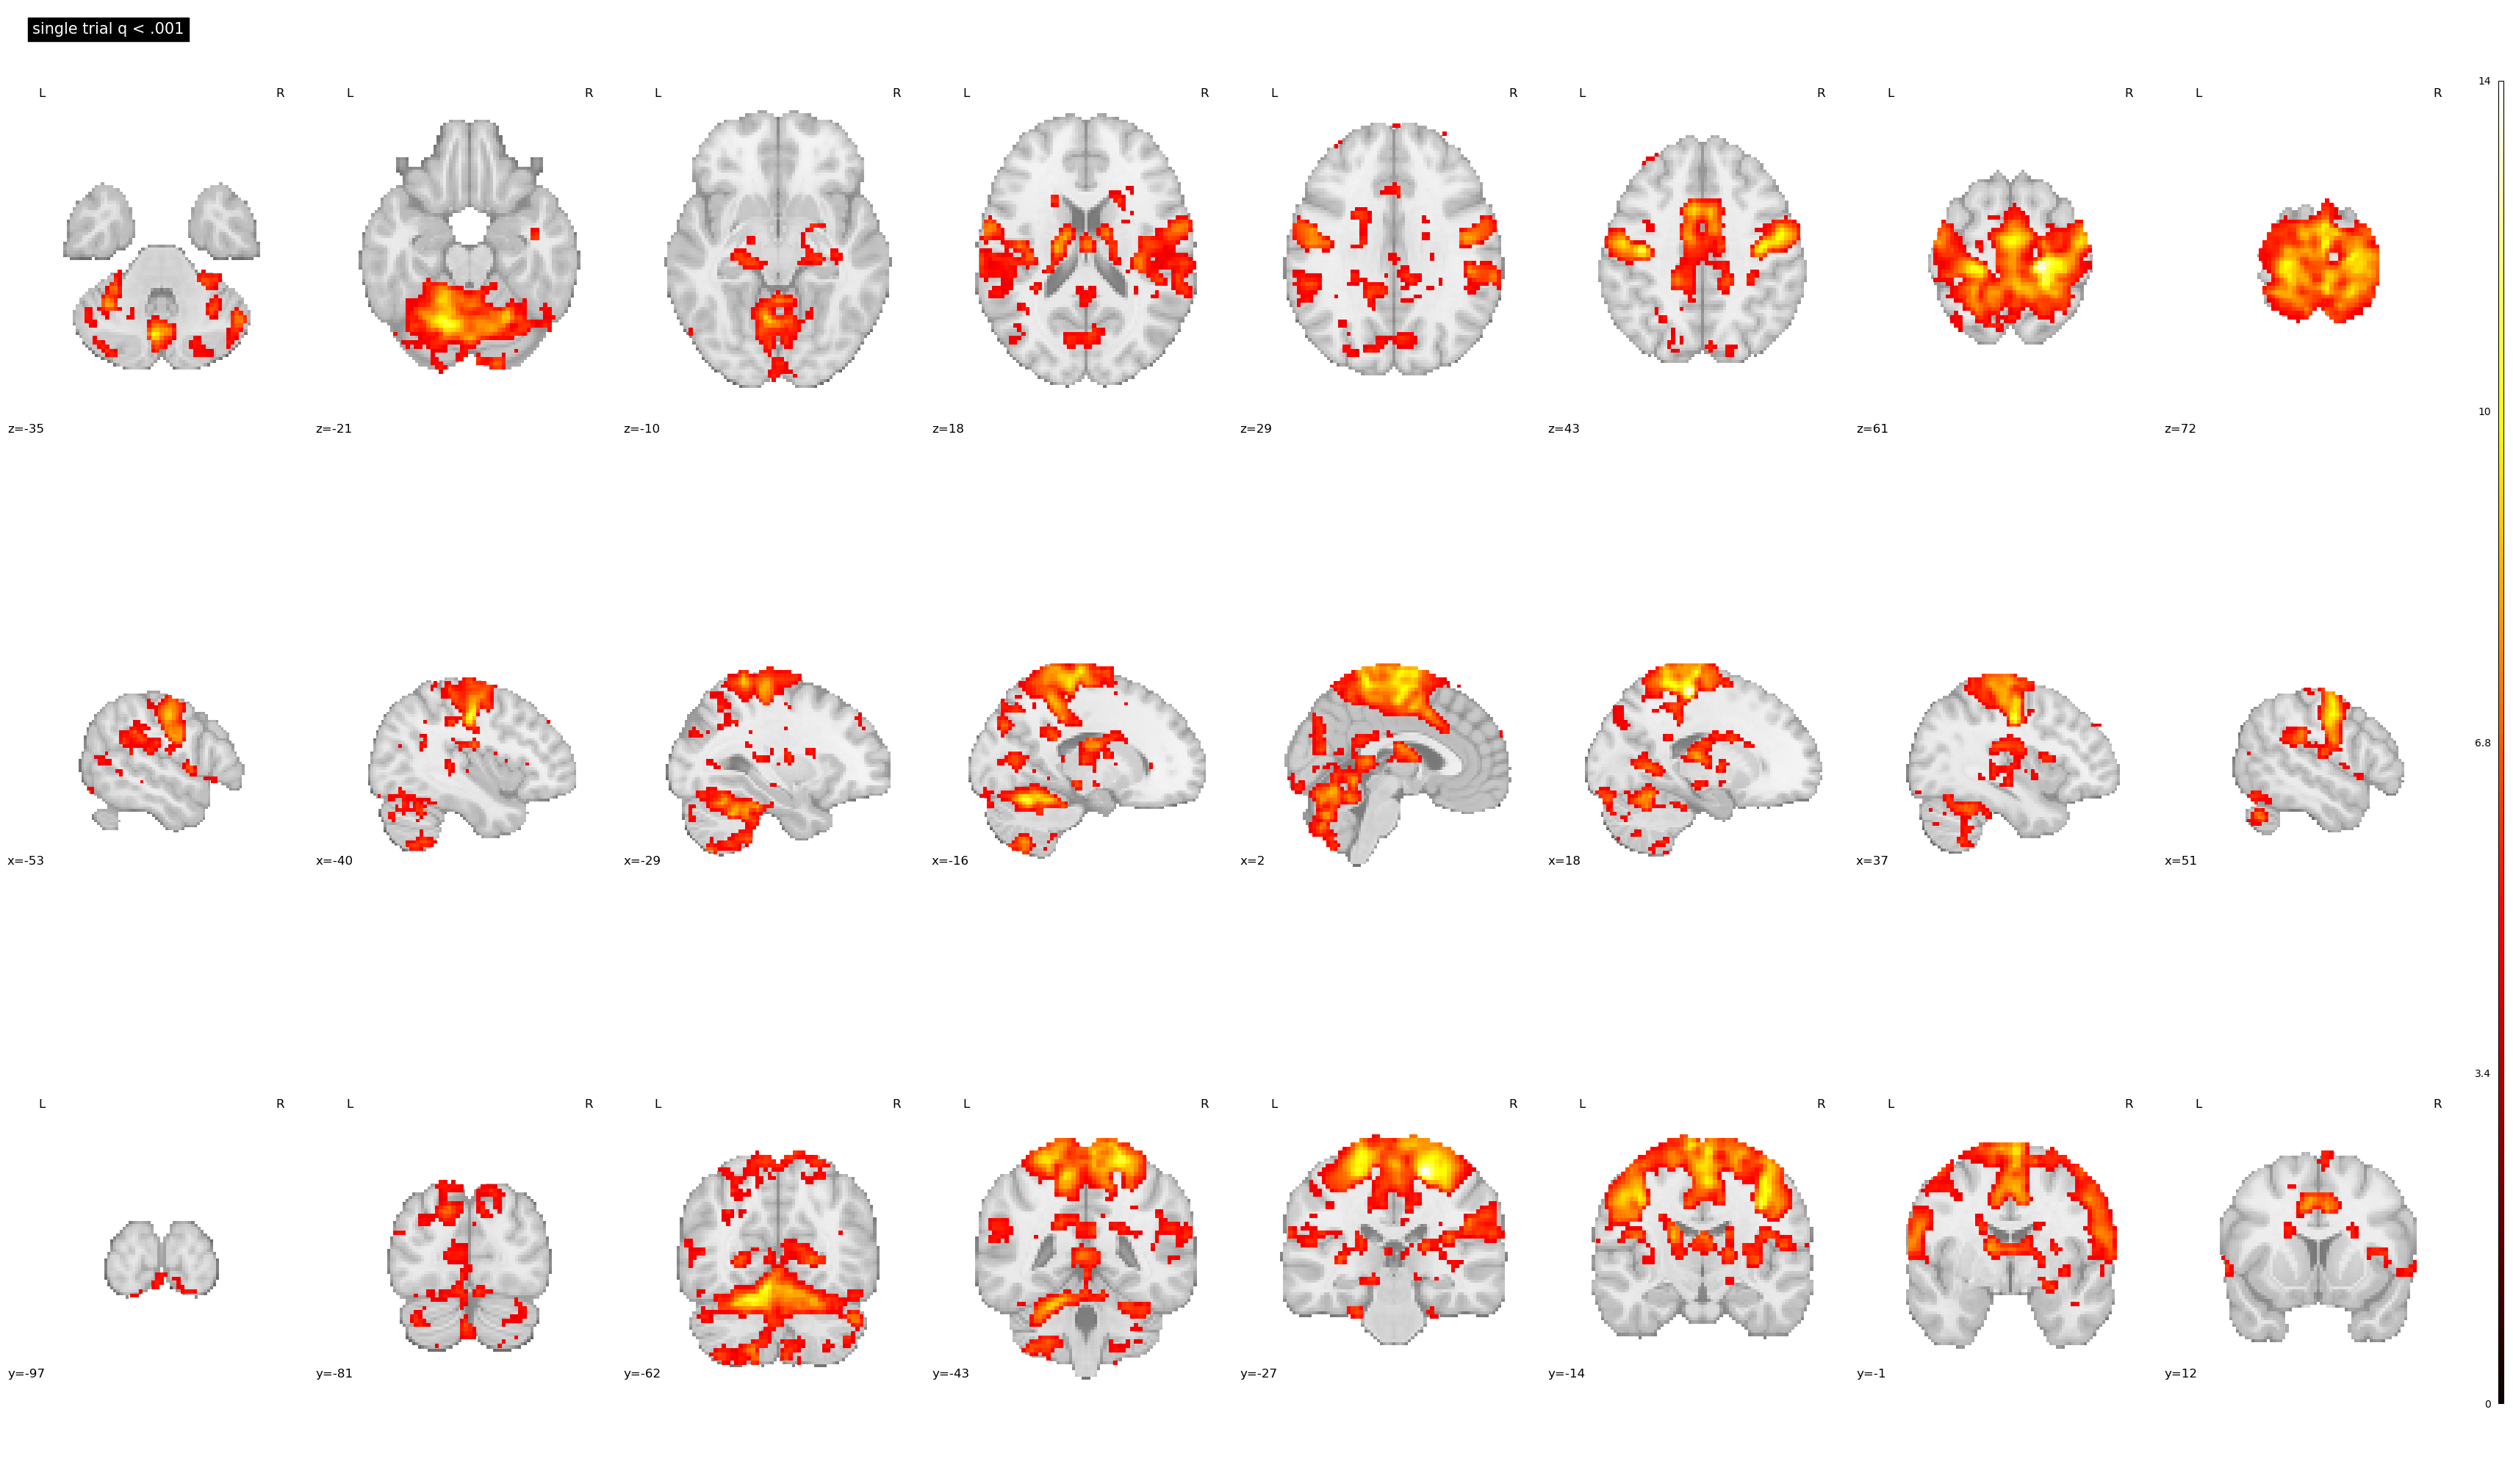

In [179]:
cut_coords = 8
plotting.plot_stat_map(con_tmap,  display_mode='mosaic', cut_coords=cut_coords, title='single trial q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode='mosaic', cut_coords=cut_coords, title='single trial q < .001')

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


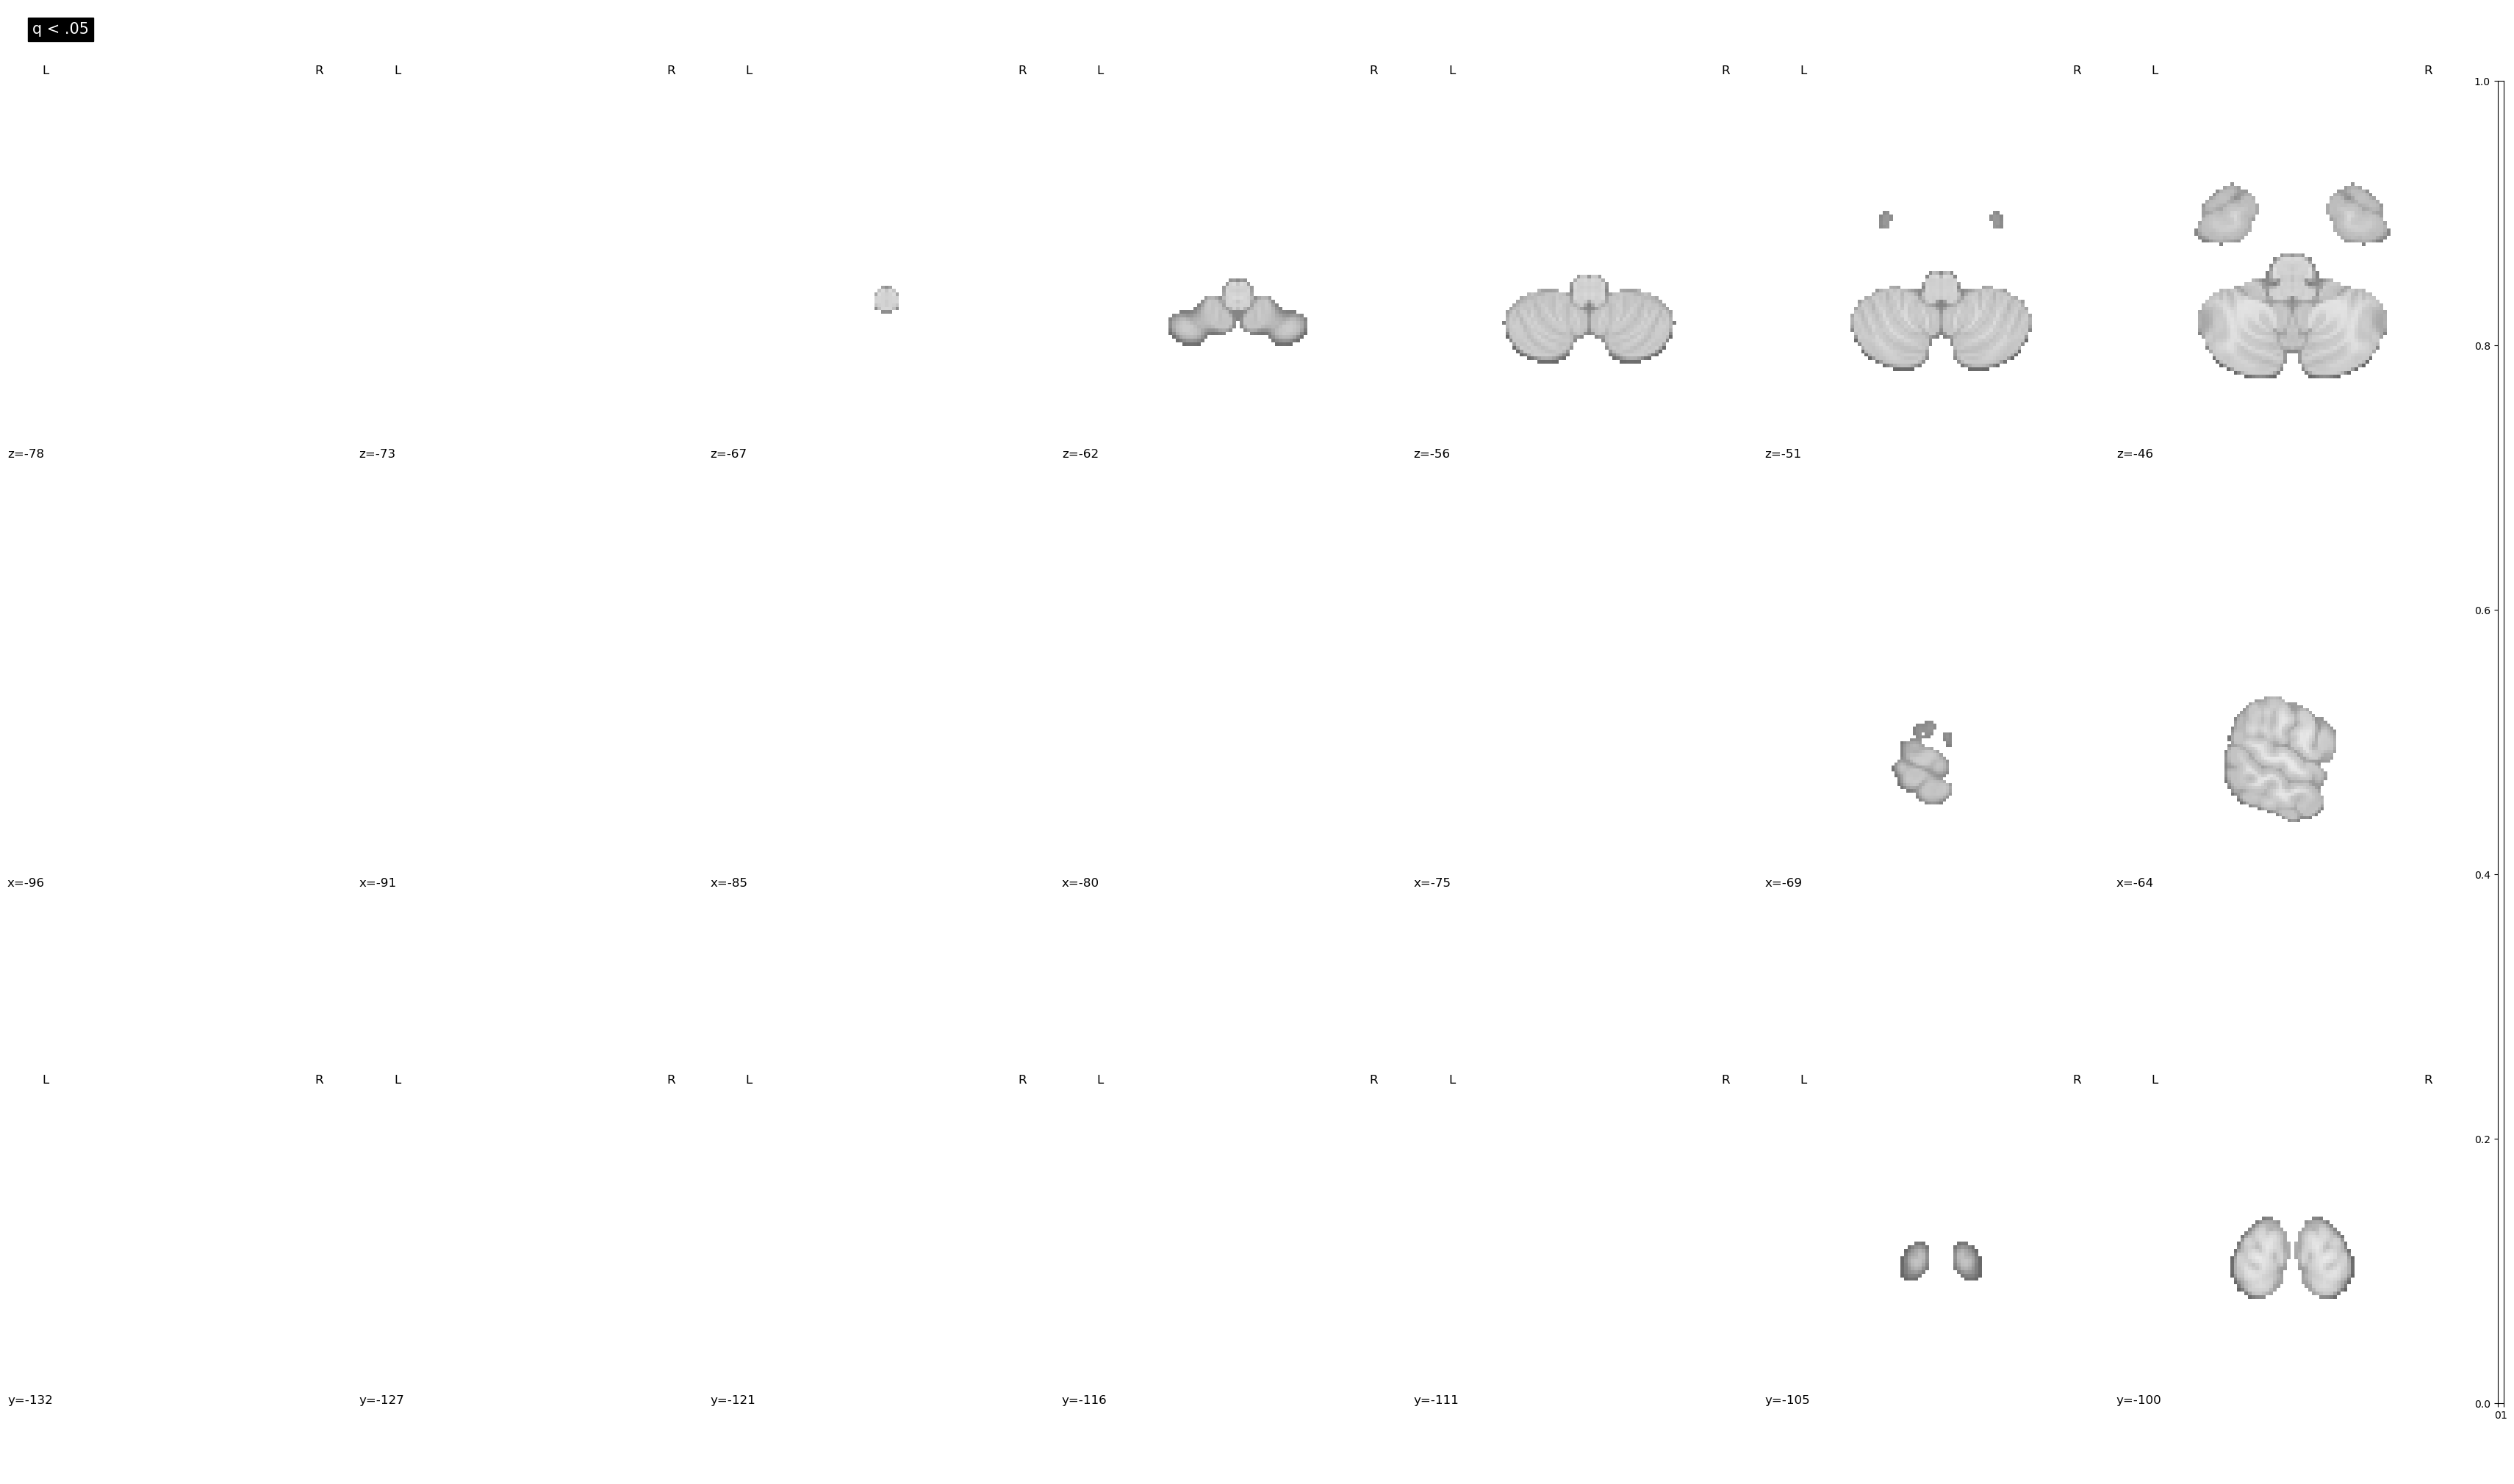

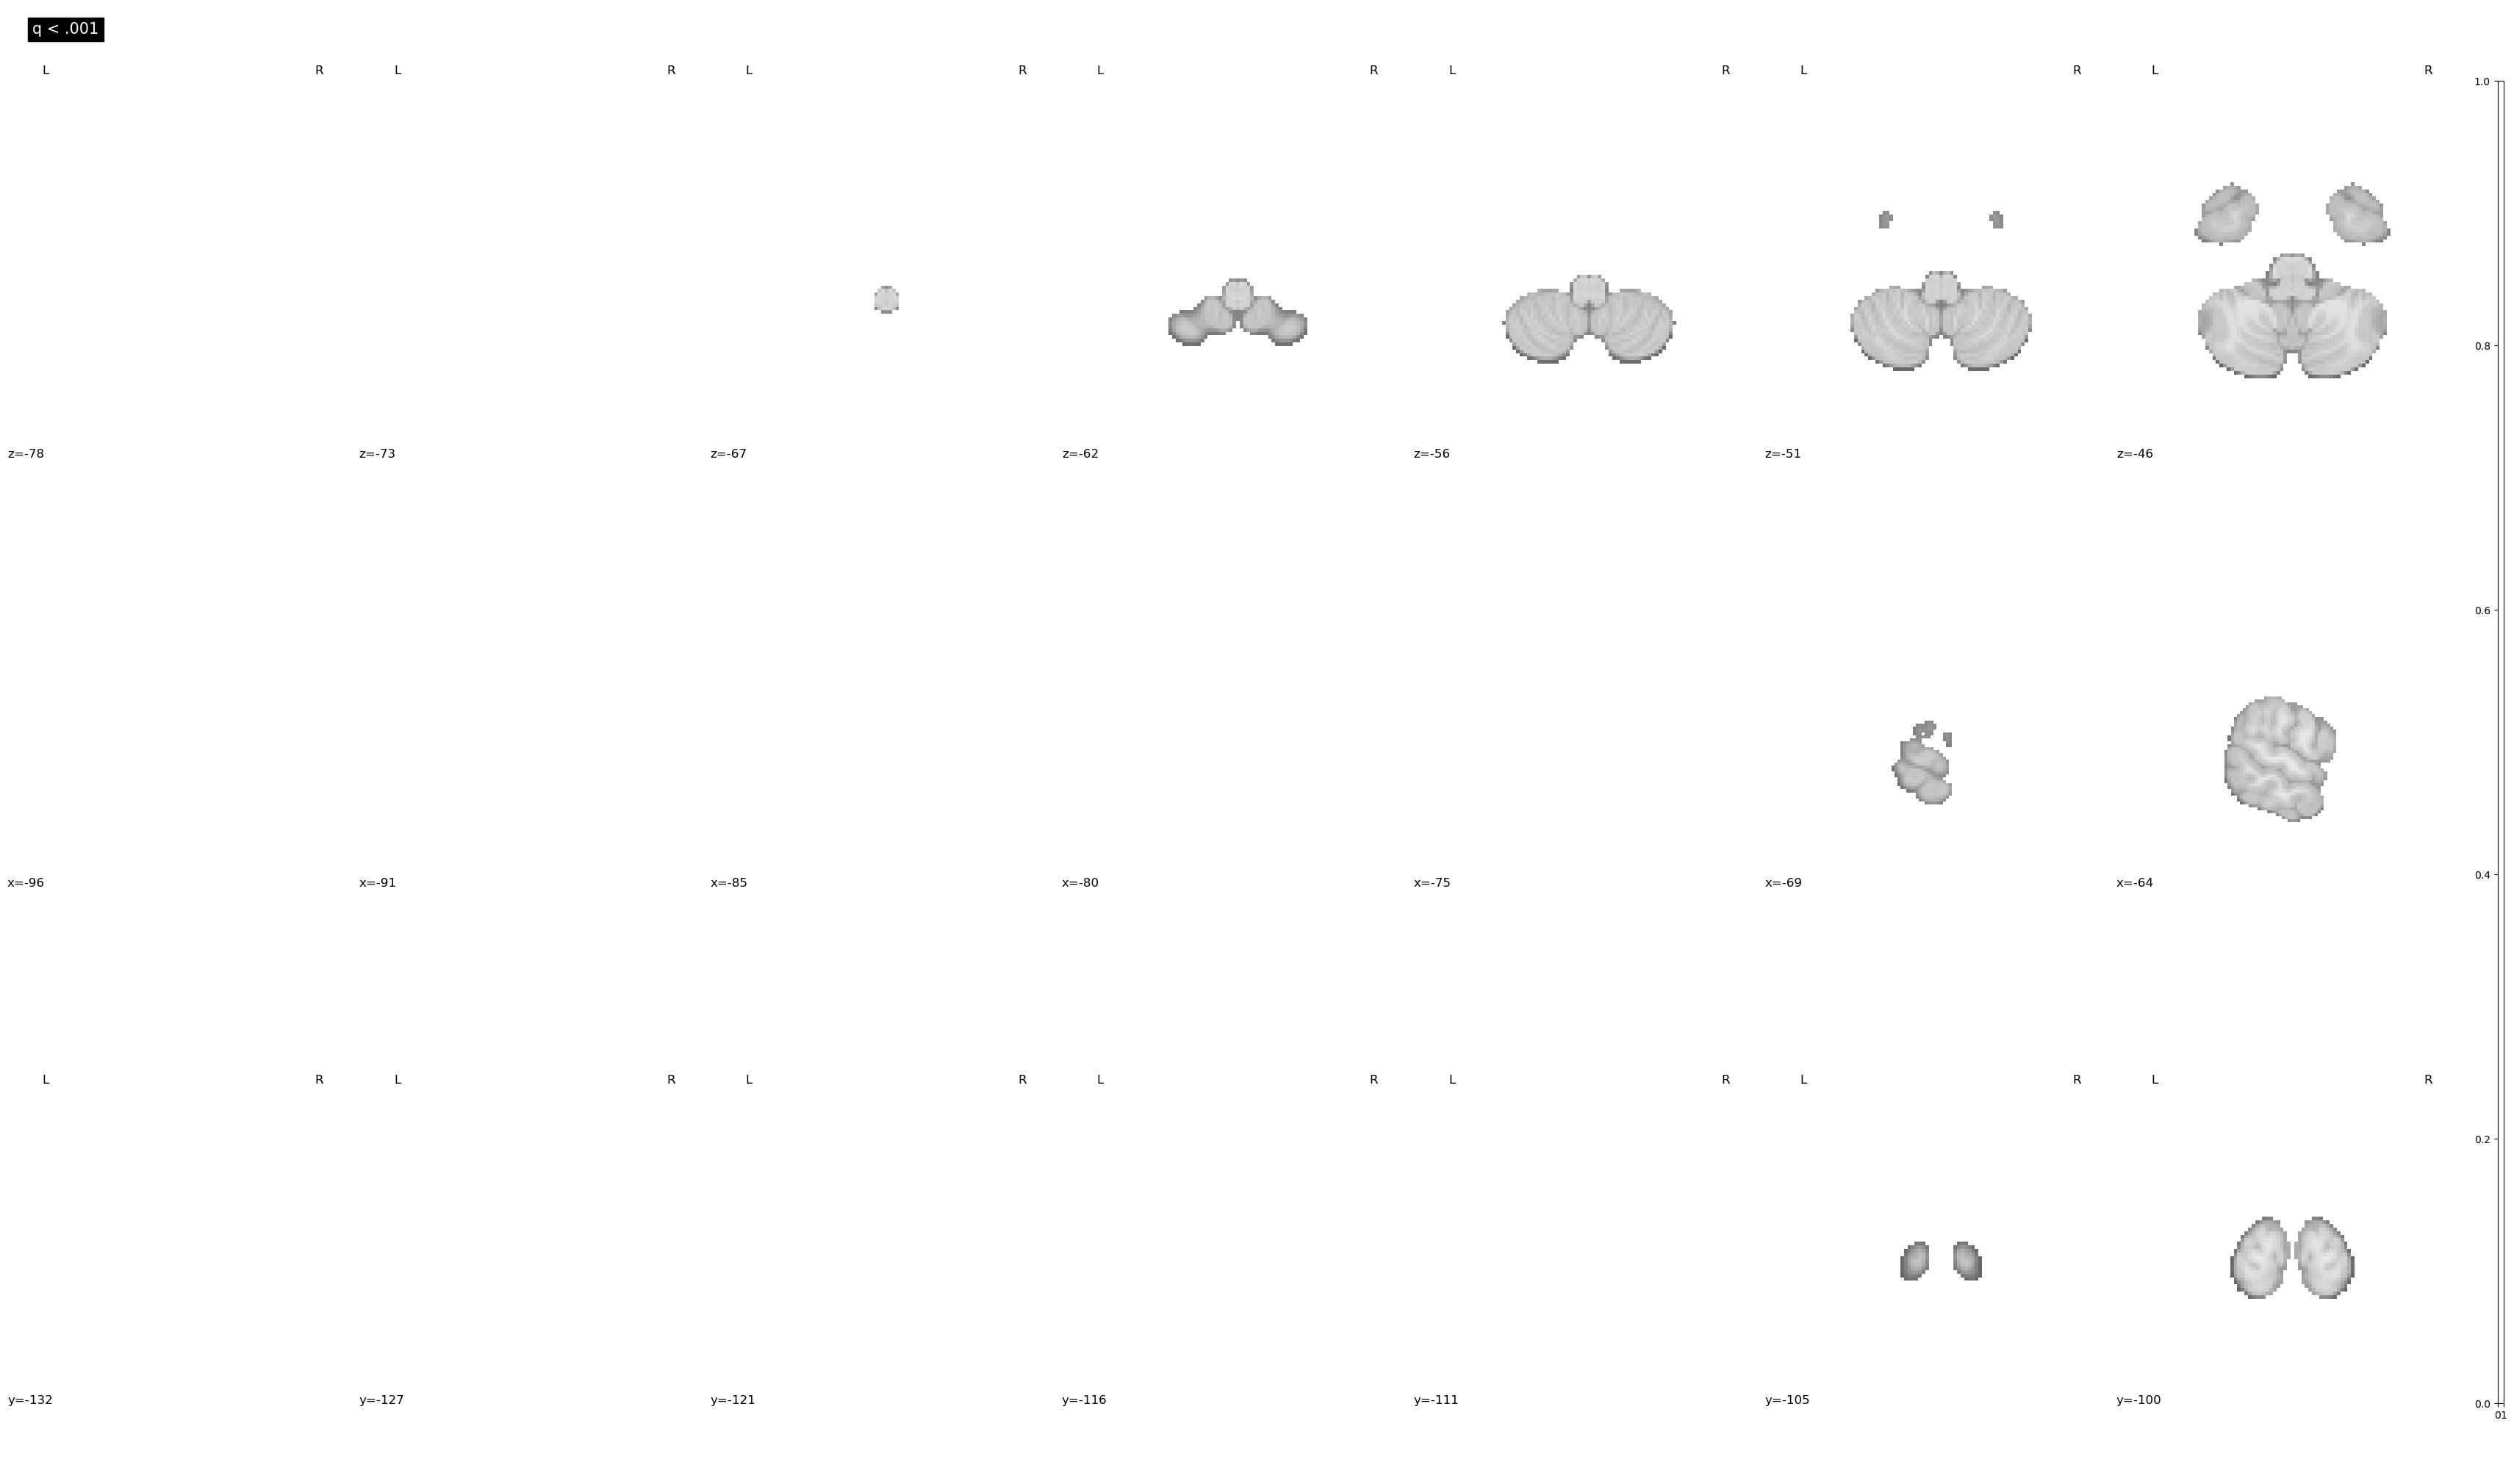

In [170]:
# SPM  Tmaps
x,y,z=ref_img.shape

spm_stack_con = spm_masker.fit_transform(con_niis)
spm_tvalues, spm_pvalues = scipy.stats.ttest_1samp(spm_stack_con, 
                                                 popmean=0,
                                                 axis=0,
                                                 #nan_policy='propagate',
                                                 alternative='two-sided' )

reject, spm_qvalues, _, _ = multitest.multipletests(spm_pvalues, method='fdr_bh')
unthres_tmap = spm_masker.inverse_transform(spm_tvalues)

result_map = np.zeros(spm_stack_con.shape[1])
result_map[spm_qvalues < .05] = spm_tvalues[spm_qvalues < .05]
con_tmap = spm_masker.inverse_transform(result_map)

result_map_001 = np.zeros(spm_stack_con.shape[1])
result_map_001[spm_qvalues < .0001] = spm_tvalues[spm_qvalues < .0001]
con_tmap_001 = spm_masker.inverse_transform(result_map_001)

cut_coords = [(-56, -81, -43),(-40, -62, -21),(-16, -46, -5),(2, -27, 18),
(18, -11, 18),(18, -11, 43),(37, 9, 61),(51,44,75)]

plotting.plot_stat_map(con_tmap,  display_mode='mosaic', cut_coords=cut_coords, title='spm q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode='mosaic', cut_coords=cut_coords, title='spm q < .001')

In [164]:
spm_stack_con

array([[-1.3098854 , -1.3644086 , -0.9019849 , ..., -1.7024504 ,
        -1.4767363 , -1.6505115 ],
       [ 1.5480766 , -0.70499355, -0.15863337, ...,  0.3891002 ,
         0.42000377,  0.01786531],
       [-0.176961  ,  0.4912073 ,  0.39627615, ...,  1.02145   ,
         0.5684867 ,  0.93788517],
       ...,
       [-1.2231561 , -0.99047047, -0.6690175 , ..., -0.75558335,
        -0.34134614, -0.43208843],
       [-0.7075735 , -0.10395141, -0.53048587, ..., -0.9285012 ,
        -1.2358047 , -1.2362229 ],
       [ 1.0993077 ,  1.2999476 ,  1.269727  , ...,  0.02720937,
         0.0679334 ,  0.02417875]], dtype=float32)

In [163]:
# calculate correlation coefficient
corr = np.corrcoef(spm_tvalues, nilearn_tvalues)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spm_tvalues, nilearn_tvalues)[0,1]}")


* correlation between intersection of single trial and SPM: 0.02119962469651532


## problem space: 
I'm loading beta maps in SPM, whereas calculating t maps in nilearn. 
load the T maps for SPM
location:`/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model03_18reg/2ndlevel/model03-18reg_epoch-stim_dummy-stimlinear_P_simple_STIM_stimlin_high_gt_low_fdr-001.nii`

In [171]:
spm_fdrt = image.load_img('/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model03_18reg/2ndlevel/model03-18reg_epoch-stim_dummy-stimlinear_P_simple_STIM_stimlin_high_gt_low_fdr-05.nii')
spm_masked = nifti_masker.fit_transform(
    new_img_like(ref_img, spm_fdrt.get_fdata()))
    
corr = np.corrcoef(spm_masked.ravel(), nilearn_tvalues)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spm_masked.ravel(), nilearn_tvalues)[0,1]}")


* correlation between intersection of single trial and SPM: 0.8323668609204367


In [184]:
spm_masked.shape

(1, 98053)

In [180]:
spm_fdrt = image.load_img('/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model03_18reg/2ndlevel/model03-18reg_epoch-stim_dummy-stimlinear_P_simple_STIM_stimlin_high_gt_low_fdr-05.nii')
spm_masked = spm_masker.fit_transform(
    new_img_like(ref_img, spm_fdrt.get_fdata()))

nilearn_array = nifti_masker.fit_transform(con_tmap)
corr = np.corrcoef(spm_masked.ravel(), nilearn_array)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spm_masked.ravel(), nilearn_tvalues)[0,1]}")


* correlation between intersection of single trial and SPM: 0.8305503295062423


# correlation between intersection of single trial and SPM: <br>0.832

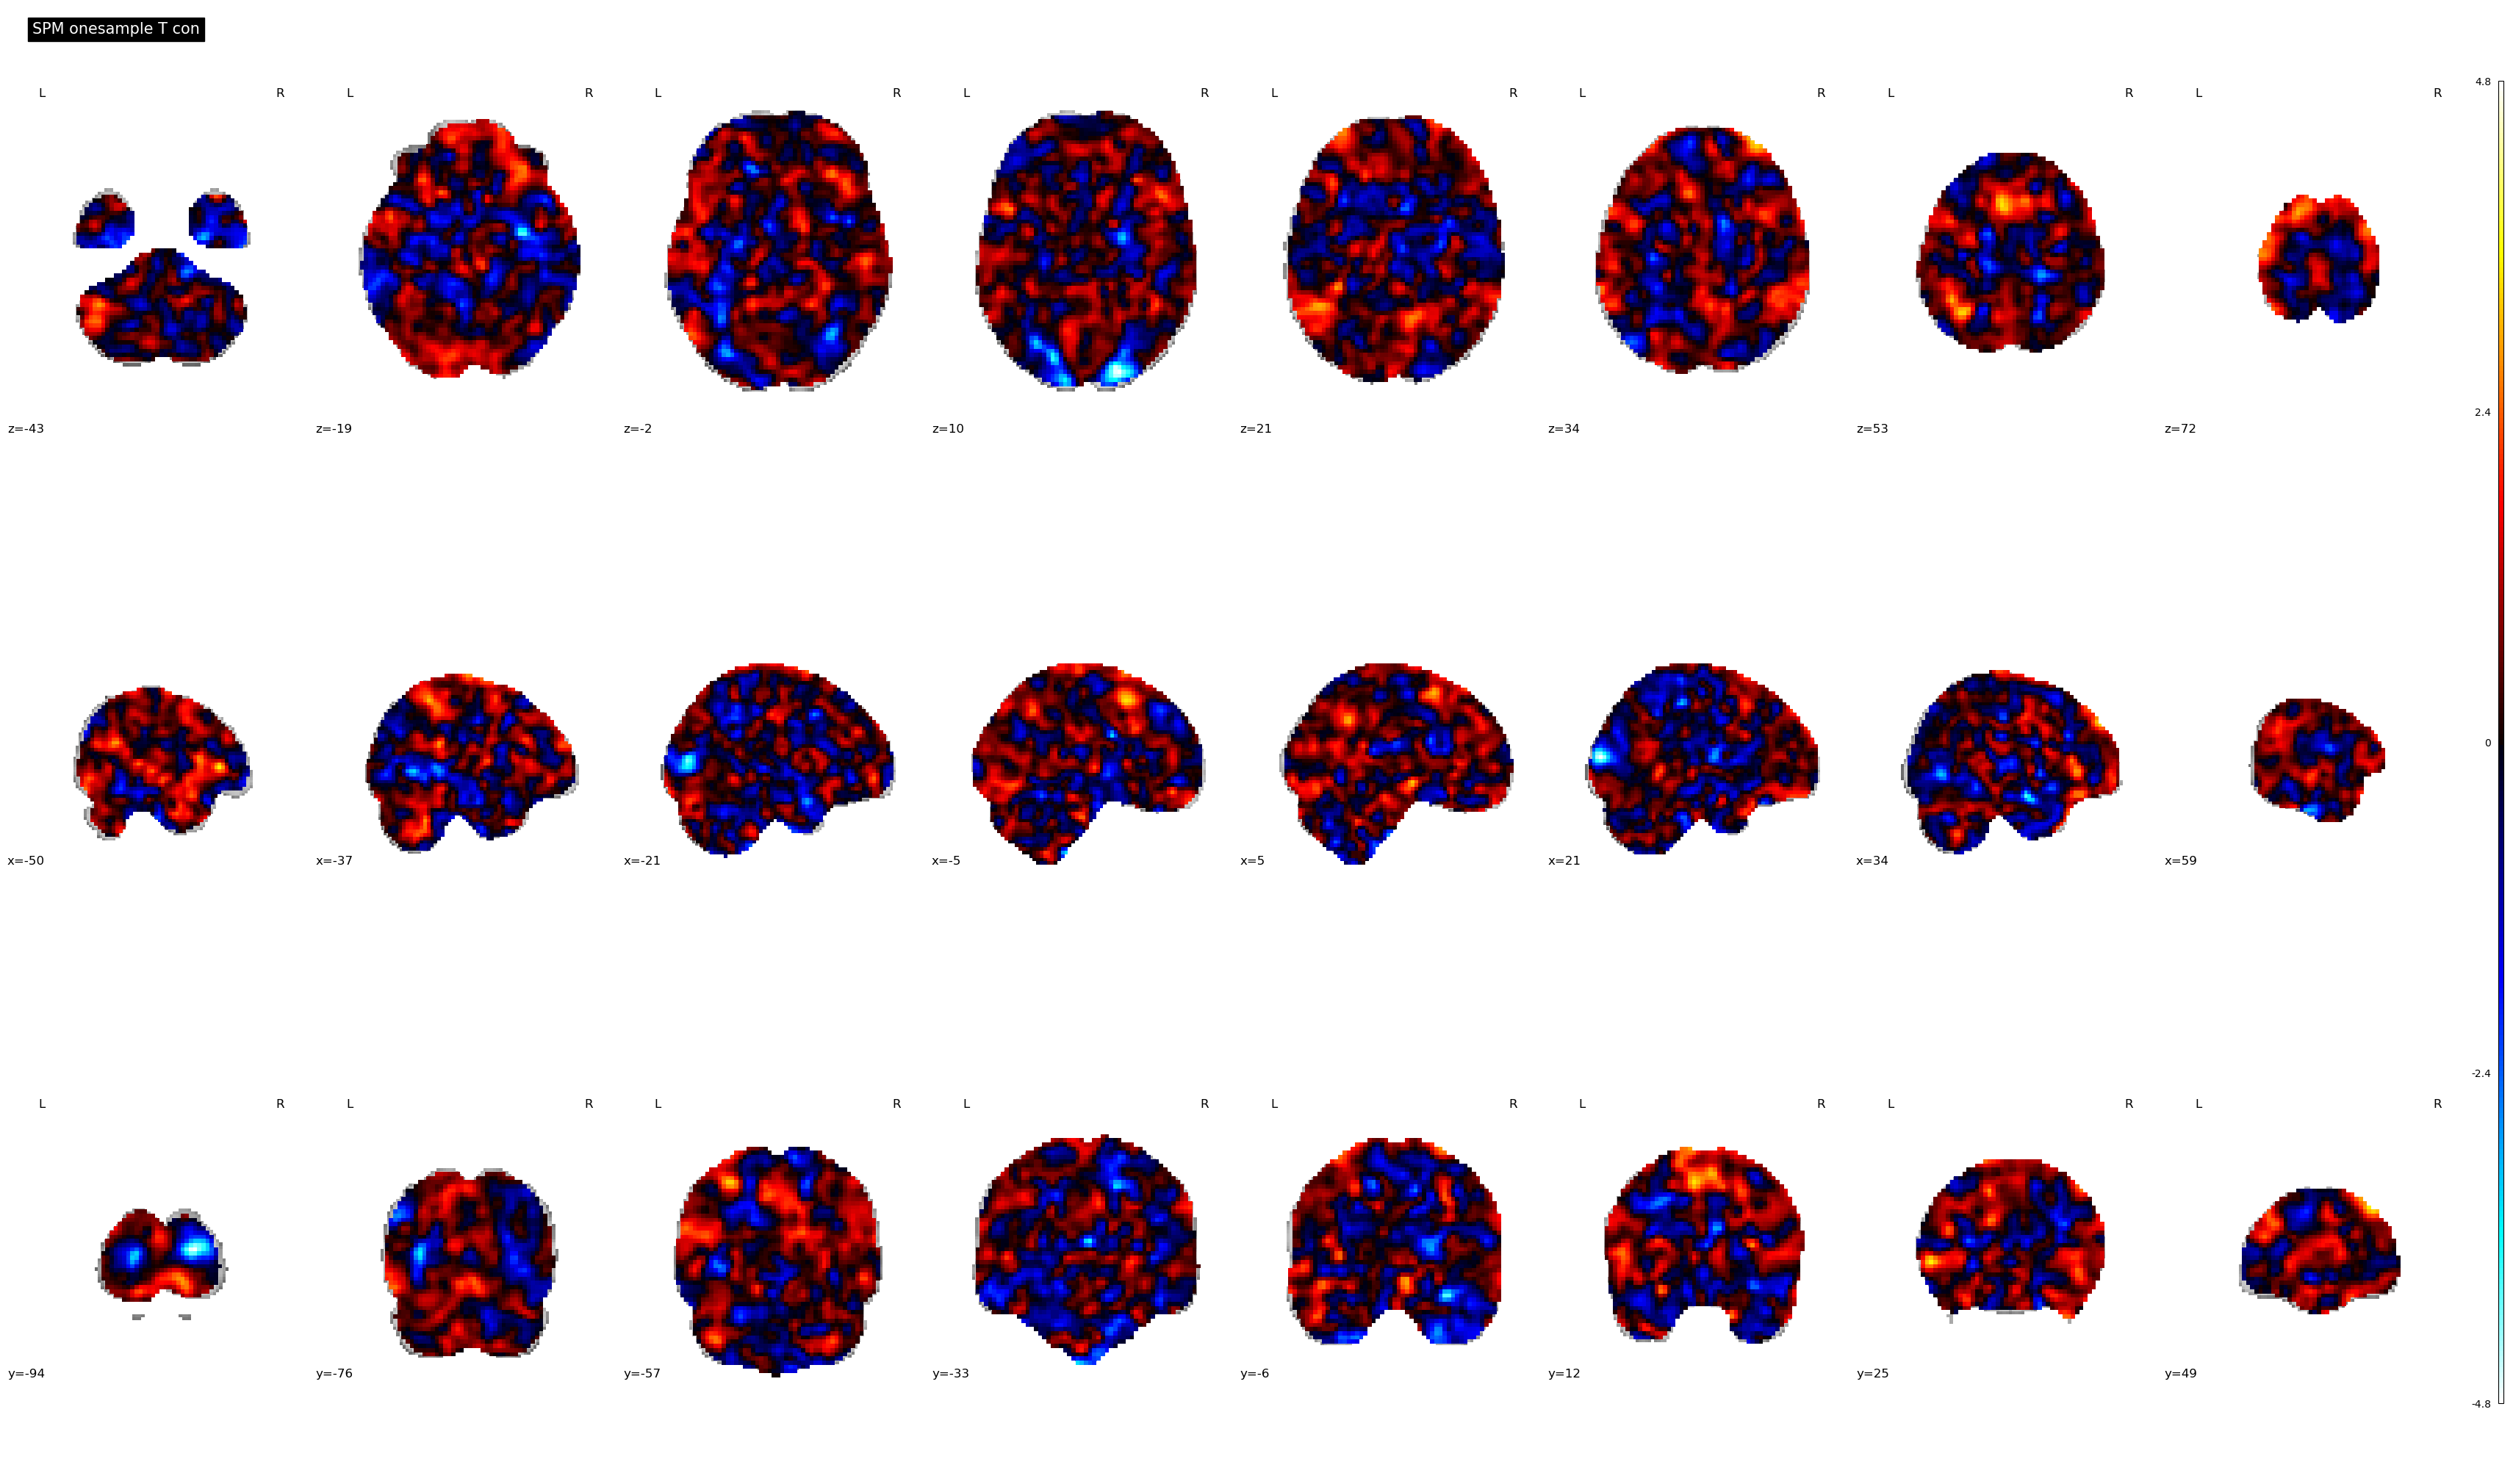

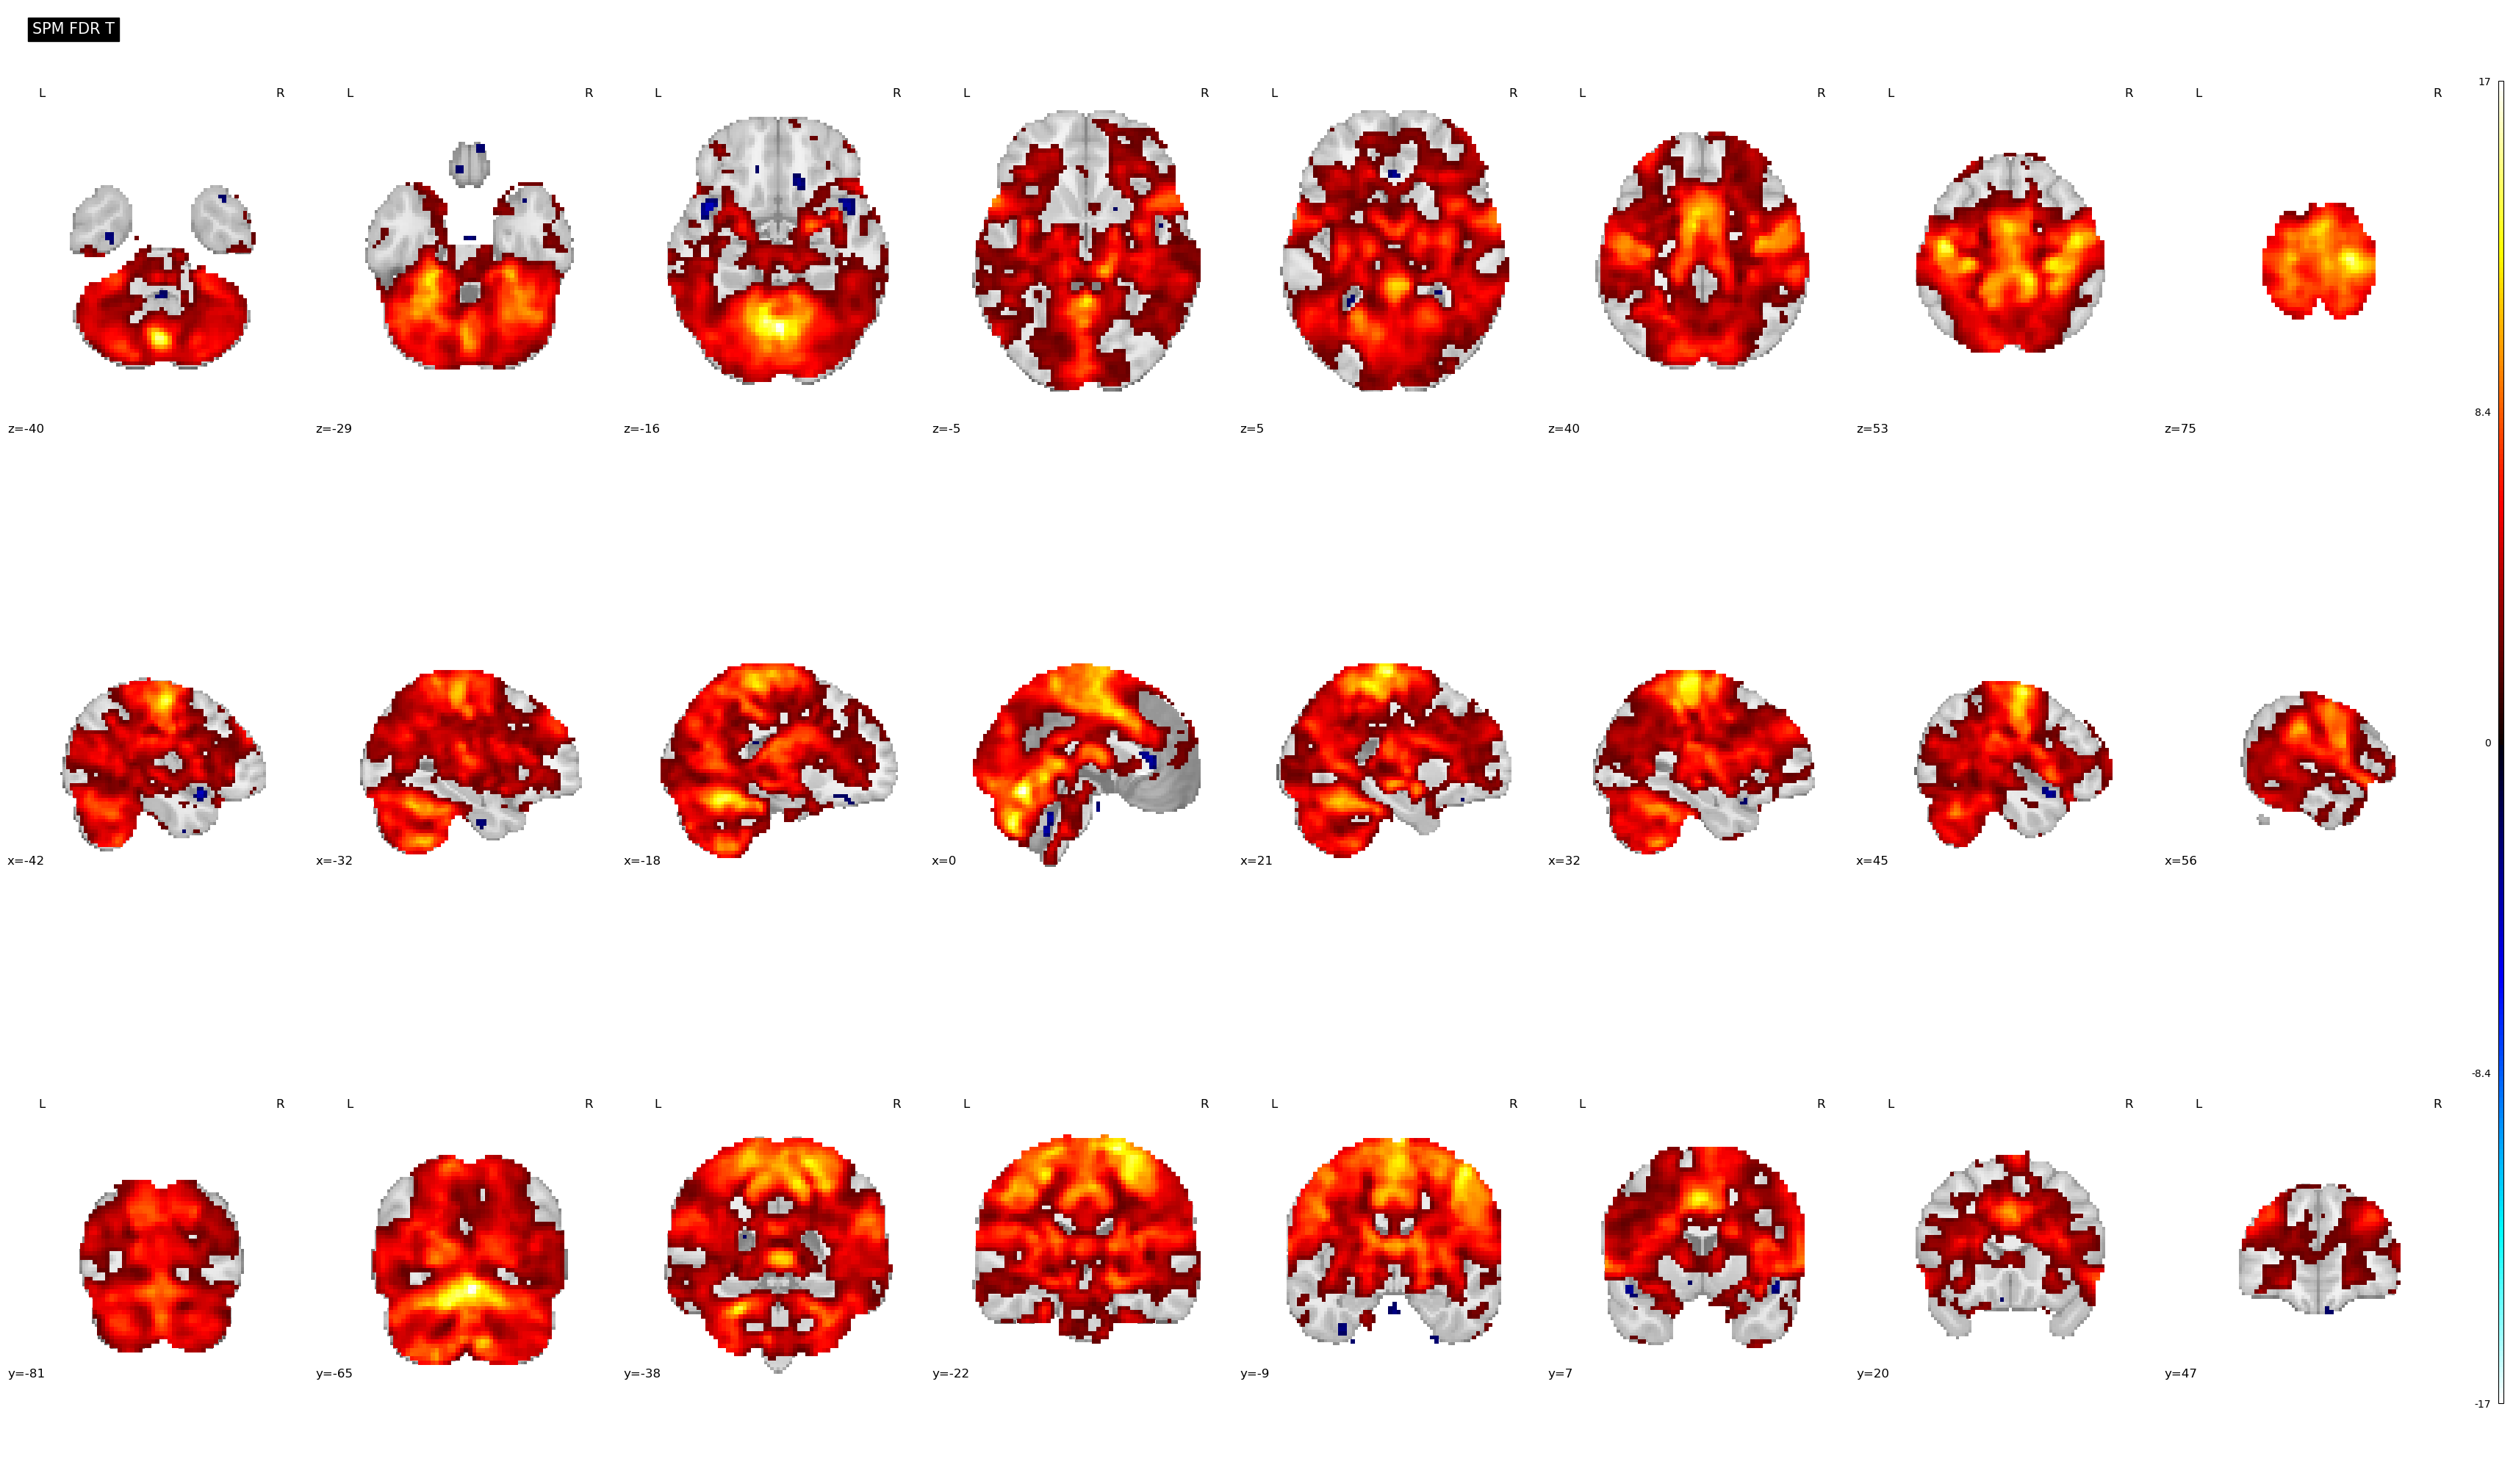

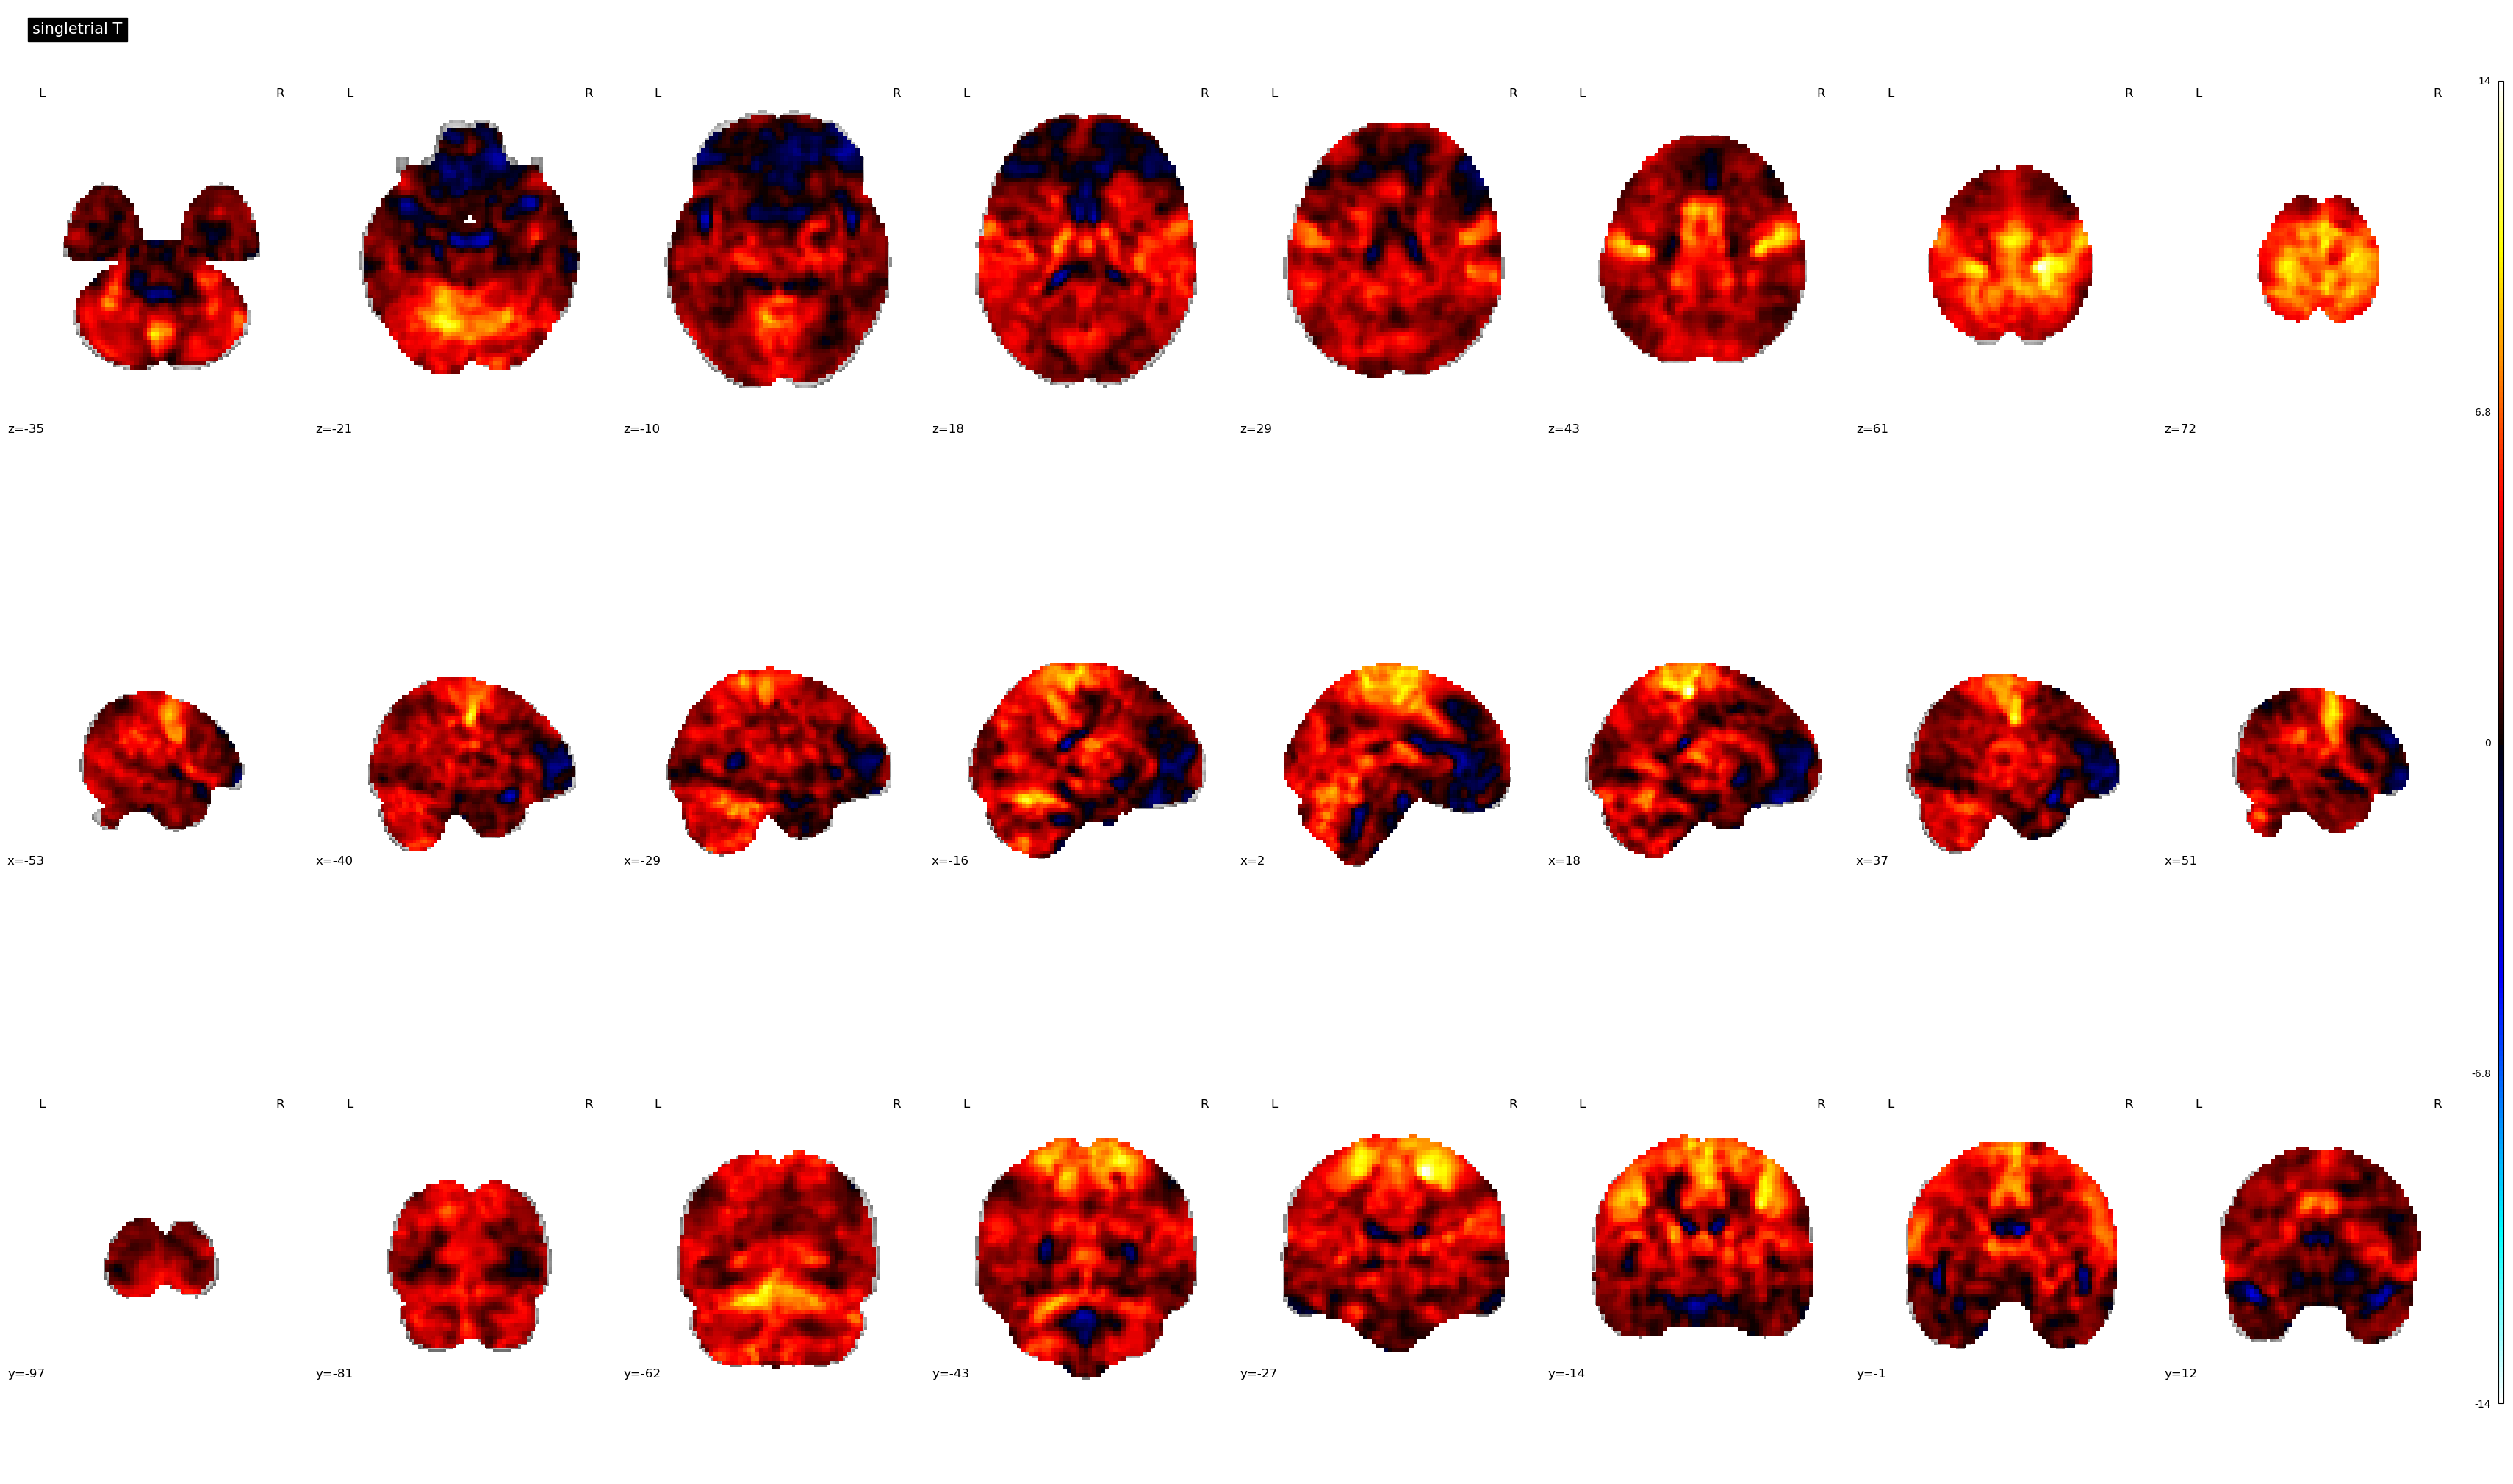

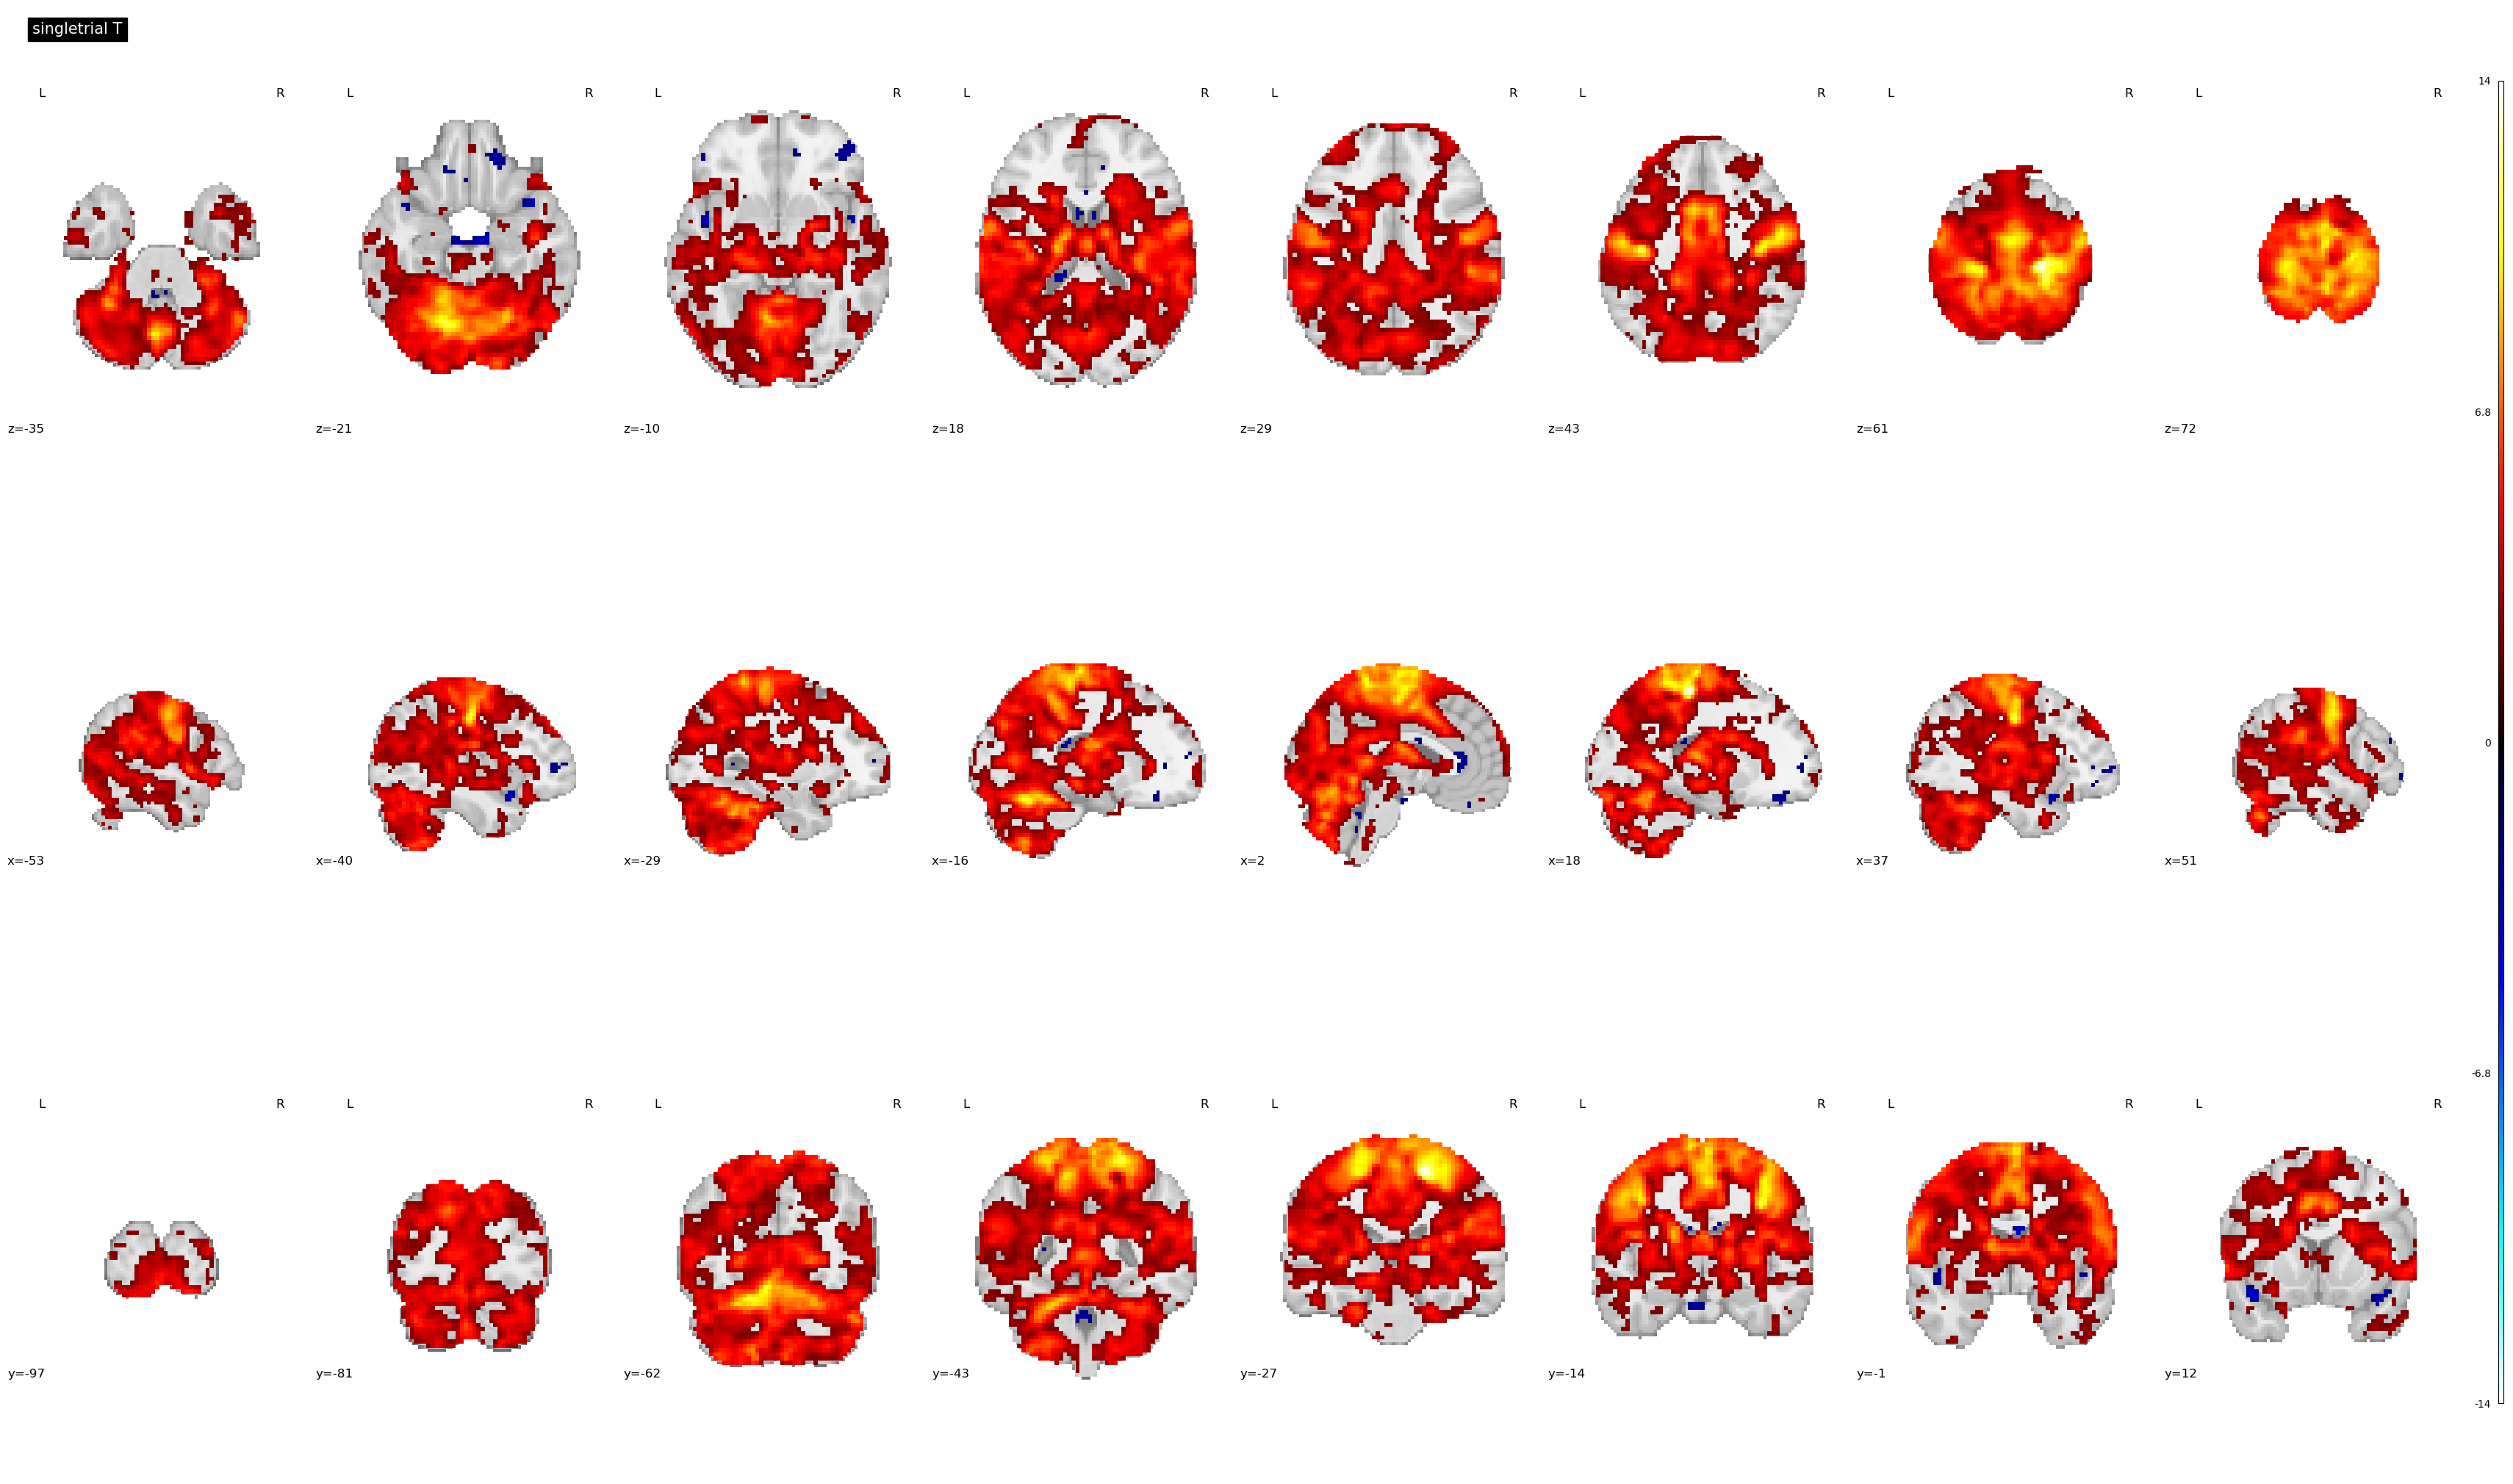

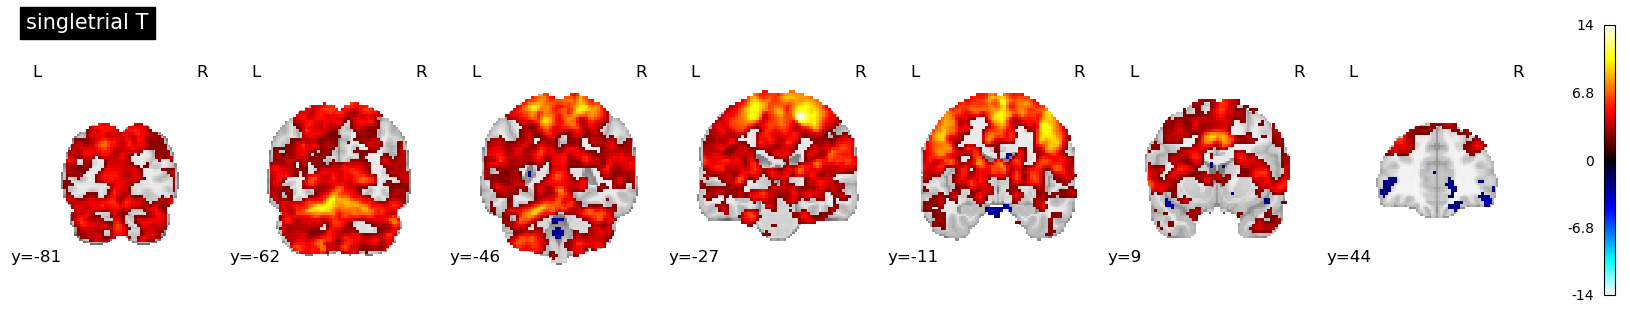

In [186]:
# plot maps
cut_coords = 8
# SPM con, one-sample t in sklearn
spm_tmapp = spm_masker.inverse_transform(spm_tvalues)
plotting.plot_stat_map(spm_tmapp, 
                       display_mode='mosaic', 
                       cut_coords=cut_coords, 
                       title='SPM onesample T con')

# SPM FDR (constructed in matlab)
plotting.plot_stat_map(spm_fdrt, 
                       display_mode='mosaic', 
                       cut_coords=cut_coords, 
                       title='SPM FDR T')

# single trial map
singletrial_tmap = nifti_masker.inverse_transform(nilearn_tvalues)
plotting.plot_stat_map(singletrial_tmap, 
                       display_mode='mosaic', 
                       cut_coords=cut_coords, 
                       title='singletrial T')

plotting.plot_stat_map(con_tmap, 
                       display_mode='mosaic', 
                       cut_coords=cut_coords, 
                       title='singletrial T')


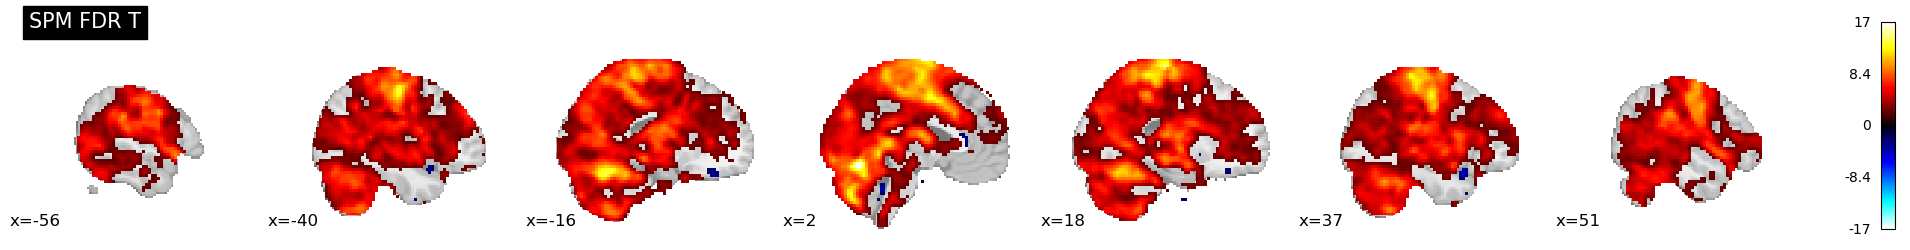

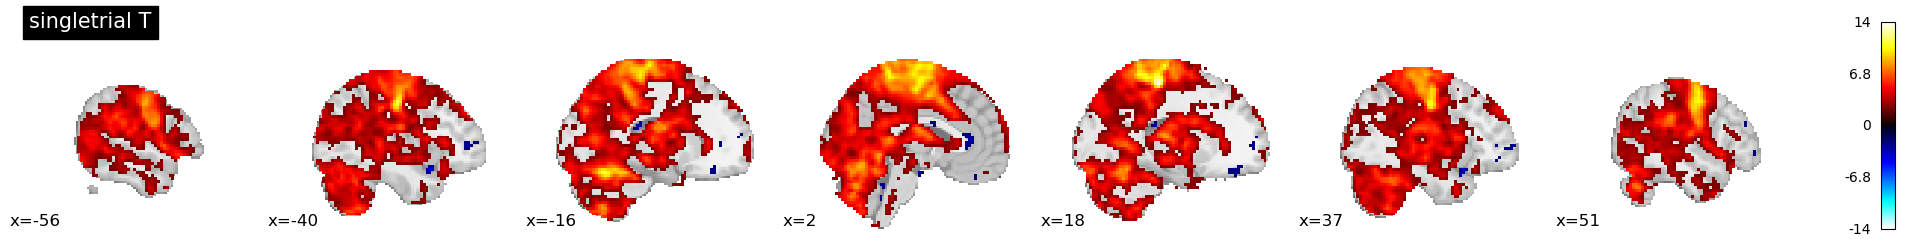

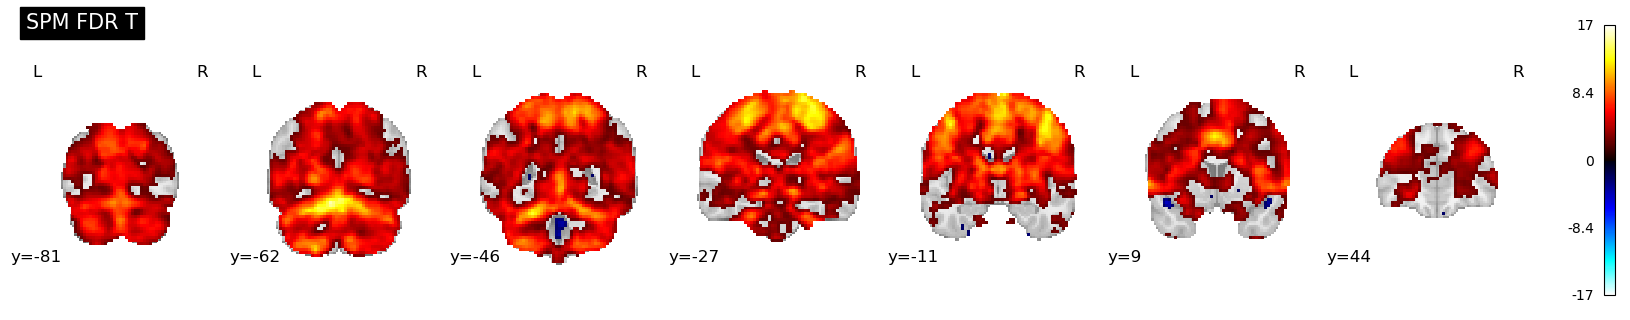

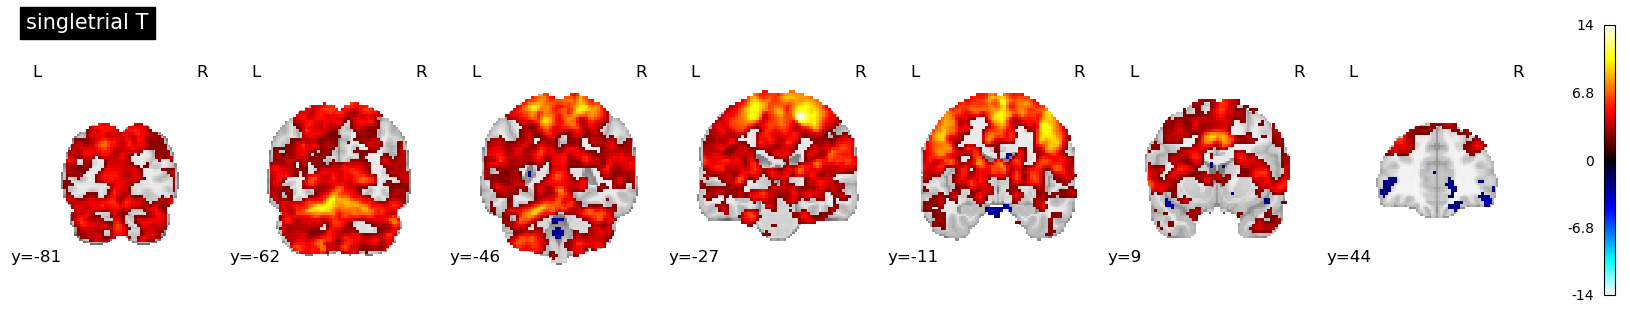

In [188]:
# SPM FDR y
plotting.plot_stat_map(spm_fdrt,
                       display_mode='x', 
                       cut_coords=(-56, -40, -16, 2, 18, 37, 51),
                       title='SPM FDR T')
# single trial y
plotting.plot_stat_map(con_tmap, 
                       display_mode='x', 
                       cut_coords=(-56, -40, -16, 2, 18, 37, 51), 
                       title='singletrial T')

# SPM FDR y
plotting.plot_stat_map(spm_fdrt,
                       display_mode='y', 
                       cut_coords=(-81, -62, -46, -27, -11, 9, 44), 
                       title='SPM FDR T')
# single trial y
plotting.plot_stat_map(con_tmap, 
                       display_mode='y', 
                       cut_coords=(-81, -62, -46, -27, -11, 9, 44), 
                       title='singletrial T')